# **ソフトウェア欠陥データセットによるバイナリ分類**
(Binary Classification with a Software Defects Dataset)

# 参考資料
**書籍**
- Python実践データ加工:可視化100本ノック
- ［第3版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践


**Kaggle**
- [PSS3E23 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense)
- [PS_3.23_LGBM_bin_日本語あり](https://www.kaggle.com/code/akioonodera/ps-3-23-lgbm-bin)
- [PS3E23 | Binary Classification for Beginners](https://www.kaggle.com/code/iqbalsyahakbar/ps3e23-binary-classification-for-beginners)

**記事**  

**自分で作成したファイル**
- モース硬度データセットを使用した回帰
- 生体信号を使用した喫煙者の状態のバイナリ予測

## 概要
1. 目的：ソフトウェアの欠陥確率を予測する
2. アプローチ:
3. データセット:
    1. 全ての特徴量は数値型
    2. データセットのバランスがやや取れていない
        * サンプルの23%のみが陽性クラス（defects==True）に属している
4. 目的変数： defects

それぞれの特徴量は何を表しているのかさっぱりわかりませんが、とりあえず形式を整えてモデル作成と予測を行っていきます。<br>
タイトルにもあるように「Binary Classification（二値分類、二項分類）」の問題ですので、objectiveとしてはbinary、metricはbinary_loglossを使います。<br>
オリジナルデータが存在するようなので、これも使っていきますが、このコンペで提供されているデータとの重複があるようですので、重複する部分のデータは削除します。また、このオリジナルデータを使うためには以下の注意が必要です。<br>
次の５つの特徴量には、浮動小数点のデータが格納されているべきですが、一部「?」が格納されていますので、これらのデータを欠損値に置き換えます。<br>
注意しなければならないのは、「?」が格納されていたせいで、これらの特徴量のデータ型が「object」になってしまっている点です。これらについてはastype(float)を使ってfloat型に変換します。<br>
【「?」が格納されている特徴量】<br>
uniq_Op<br>uniq_Opnd<br>total_Op<br>total_Opnd<br>branchCount<br>
<br>

### 各特徴量の日本語訳
#### Japanese
データセットの9つのカラムは「導出された指標」
- P = volume = V = N * log2(mu) (長さNのプログラムを書くために必要な精神的比較の数)
- V* = minimal implementationでのvolume = (2 + mu2')*log2(2 + mu2')
- L  = プログラムの長さ = V*/N
- D  = 難易度 = 1/L
- L' = 1/D
- I  = 知能 = L'*V'
- E  = プログラムを書くための労力 = V/L
- T  = プログラムを書くのにかかる時間 = E/18 秒

#### 評価指標：　Area Under the ROC Curve(AUC)
- ROC曲線に基づくモデルの評価指標
- ROC曲線と横軸で囲まれる面積の値
- 大小比較を行い相対的な順番を与える
- 不均衡データ（imbalanced data）下におけるモデルの評価時にも耐えられる指標

# ライブラリ・データセットのインポート

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', 30)
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
plt.style.use('ggplot')

In [2]:
from sklearn.ensemble import RandomForestRegressor # 特徴量の重要度評価で用いる
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

## 実行時間を調べるために使う

In [3]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [4]:
FILE_PATH = '/Users/ootsuka/Desktop/プログラミング/Kaggle/ソフトウェア欠陥データセットによるバイナリ分類/input/'
OUTPUT_DIR = '/Users/ootsuka/Desktop/プログラミング/Kaggle/ソフトウェア欠陥データセットによるバイナリ分類/output/'

train = pd.read_csv(FILE_PATH +'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数の分割

In [5]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['defects'].astype(int)
target_name = str(train.iloc[:, [21]].columns.tolist()) # カラム数-2の値が目的変数

## データ(DataFrame)の構成を調べる

In [6]:
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [7]:
test.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,22636.74,0.27,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,14482.46,0.22,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,116160.08,1.28,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,16135.47,0.29,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,2624.49,0.08,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0


In [11]:
print('train: ')
print(train.shape)
print(train.info())

train: 
(101763, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-

In [12]:
print('test: ')
print(test.shape)
print(test.info())

test: 
(67842, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67842 entries, 0 to 67841
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                67842 non-null  float64
 1   v(g)               67842 non-null  float64
 2   ev(g)              67842 non-null  float64
 3   iv(g)              67842 non-null  float64
 4   n                  67842 non-null  float64
 5   v                  67842 non-null  float64
 6   l                  67842 non-null  float64
 7   d                  67842 non-null  float64
 8   i                  67842 non-null  float64
 9   e                  67842 non-null  float64
 10  b                  67842 non-null  float64
 11  t                  67842 non-null  float64
 12  lOCode             67842 non-null  int64  
 13  lOComment          67842 non-null  int64  
 14  lOBlank            67842 non-null  int64  
 15  locCodeAndComment  67842 non-null  int64  
 16  uni

In [13]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [14]:
with pd.option_context('display.max_rows', 8):
    display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,11268.27,0.19,626.01,23,0,2,0,18.0,20.0,67.0,40.0,9.0,False
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,0.12,327.43,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,0.06,85.22,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,0.57,4278.43,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


In [15]:
with pd.option_context('display.max_rows', 8):
    display(test)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,22636.74,0.27,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,14482.46,0.22,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,116160.08,1.28,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,16135.47,0.29,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67838,20.0,3.0,1.0,3.0,38.0,161.42,0.15,6.75,23.28,1060.92,0.05,58.94,15,0,3,0,9.0,10.0,23.0,15.0,5.0
67839,24.0,2.0,1.0,2.0,52.0,240.00,0.11,9.00,26.67,2160.00,0.08,120.00,18,0,4,0,16.0,16.0,36.0,18.0,3.0
67840,18.0,2.0,1.0,1.0,49.0,216.64,0.11,9.33,24.02,2118.30,0.08,117.68,12,0,2,0,8.0,12.0,29.0,22.0,3.0
67841,101.0,15.0,10.0,5.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.0,0.0,0.0,0.0,29.0


## データ型を理解する

In [16]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object
float64    17
int64       4
bool        1
Name: count, dtype: int64


test: 
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e 

すべての変数が数値（int64, float64）  
目的変数はbool型

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [14]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
loc,101763.000000,37.347160,54.600401,1.000000,13.000000,22.000000,42.000000,3442.000000
v(g),101763.000000,5.492684,7.900855,1.000000,2.000000,3.000000,6.000000,404.000000
ev(g),101763.000000,2.845022,4.631262,1.000000,1.000000,1.000000,3.000000,165.000000
iv(g),101763.000000,3.498826,5.534541,1.000000,1.000000,2.000000,4.000000,402.000000
n,101763.000000,96.655995,171.147191,0.000000,25.000000,51.000000,111.000000,8441.000000
v,101763.000000,538.280956,1270.791601,0.000000,97.670000,232.790000,560.250000,80843.080000
l,101763.000000,0.111634,0.100096,0.000000,0.050000,0.090000,0.150000,1.000000
d,101763.000000,13.681881,14.121306,0.000000,5.600000,9.820000,18.000000,418.200000
i,101763.000000,27.573007,22.856742,0.000000,15.560000,23.360000,34.340000,569.780000
e,101763.000000,20853.589876,190571.405427,0.000000,564.730000,2256.230000,10193.240000,16846621.120000


In [15]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
loc,67842.000000,37.855945,55.793918,1.000000,13.000000,22.000000,42.000000,1891.000000
v(g),67842.000000,5.559462,8.237389,1.000000,2.000000,3.000000,6.000000,470.000000
ev(g),67842.000000,2.857699,4.666370,1.000000,1.000000,1.000000,3.000000,165.000000
iv(g),67842.000000,3.535715,5.339085,1.000000,1.000000,2.000000,4.000000,402.000000
n,67842.000000,98.222178,179.123492,0.000000,25.000000,51.000000,111.000000,8441.000000
v,67842.000000,548.422497,1318.416828,0.000000,96.210000,232.790000,560.250000,80843.080000
l,67842.000000,0.111521,0.100840,0.000000,0.040000,0.090000,0.140000,1.000000
d,67842.000000,13.762472,14.487425,0.000000,5.500000,9.820000,18.000000,418.200000
i,67842.000000,27.635377,23.420521,0.000000,15.540000,23.230000,34.270000,569.780000
e,67842.000000,22164.320048,207276.970847,0.000000,562.940000,2276.780000,10112.427500,16846621.120000


In [23]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

,count,nunique,%unique,null,type,count,mean,std,min,25%,50%,75%,max
loc,101763,378,0.371451,0,float64,101763.0,37.347160,54.600401,1.0,13.00,22.00,42.00,3442.00
v(g),101763,106,0.104164,0,float64,101763.0,5.492684,7.900855,1.0,2.00,3.00,6.00,404.00
ev(g),101763,71,0.069770,0,float64,101763.0,2.845022,4.631262,1.0,1.00,1.00,3.00,165.00
iv(g),101763,84,0.082545,0,float64,101763.0,3.498826,5.534541,1.0,1.00,2.00,4.00,402.00
n,101763,836,0.821517,0,float64,101763.0,96.655995,171.147191,0.0,25.00,51.00,111.00,8441.00
v,101763,4515,4.436780,0,float64,101763.0,538.280956,1270.791601,0.0,97.67,232.79,560.25,80843.08
l,101763,55,0.054047,0,float64,101763.0,0.111634,0.100096,0.0,0.05,0.09,0.15,1.00
d,101763,3360,3.301789,0,float64,101763.0,13.681881,14.121306,0.0,5.60,9.82,18.00,418.20
i,101763,5171,5.081415,0,float64,101763.0,27.573007,22.856742,0.0,15.56,23.36,34.34,569.78
e,101763,8729,8.577774,0,float64,101763.0,20853.589876,190571.405427,0.0,564.73,2256.23,10193.24,16846621.12


In [24]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

,count,nunique,%unique,null,type,count,mean,std,min,25%,50%,75%,max
loc,67842,371,0.546859,0,float64,67842.0,3.236104,0.853380,0.693147,2.639057,3.135494,3.761200,7.545390
v(g),67842,96,0.141505,0,float64,67842.0,1.585357,0.690621,0.693147,1.098612,1.386294,1.945910,6.154858
ev(g),67842,67,0.098759,0,float64,67842.0,1.059706,0.639451,0.693147,0.693147,0.693147,1.386294,5.111988
iv(g),67842,73,0.107603,0,float64,67842.0,1.302414,0.566514,0.693147,0.693147,1.098612,1.609438,5.998937
n,67842,828,1.220483,0,float64,67842.0,3.811600,1.448033,0.000000,3.258097,3.951244,4.718499,9.040975
v,67842,4269,6.292562,0,float64,67842.0,5.196839,1.877896,0.000000,4.576874,5.454423,6.330166,11.300278
l,67842,54,0.079597,0,float64,67842.0,0.101989,0.084581,0.000000,0.039221,0.086178,0.131028,0.693147
d,67842,3106,4.578285,0,float64,67842.0,2.312505,0.951564,0.000000,1.871802,2.381396,2.944439,6.038348
i,67842,4855,7.156334,0,float64,67842.0,3.019218,1.017553,0.000000,2.805782,3.187592,3.563033,6.347004
e,67842,8160,12.027947,0,float64,67842.0,7.409073,2.824774,0.000000,6.334948,7.730957,9.221619,16.639661


In [19]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train, axis=0))
print('\n')
print('test: ')
print(np.var(test, axis=0))

train: 
loc                  2.981175e+03
v(g)                 6.242290e+01
ev(g)                2.144837e+01
iv(g)                3.063084e+01
n                    2.929107e+04
v                    1.614895e+06
l                    1.001909e-02
d                    1.994093e+02
i                    5.224255e+02
e                    3.631710e+10
b                    1.779509e-01
t                    9.727378e+07
lOCode               1.485395e+03
lOComment            3.483812e+01
lOBlank              4.073410e+01
locCodeAndComment    9.978042e-01
uniq_Op              4.555597e+01
uniq_Opnd            3.263143e+02
total_Op             1.092802e+04
total_Opnd           5.139737e+03
branchCount          2.077259e+02
defects              1.752766e-01
dtype: float64


test: 
loc                  3.112915e+03
v(g)                 6.785358e+01
ev(g)                2.177469e+01
iv(g)                2.850541e+01
n                    3.208475e+04
v                    1.738197e+06
l               

### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [29]:
train.std() / train.mean()

loc                  1.461969
v(g)                 1.438432
ev(g)                1.627847
iv(g)                1.581828
n                    1.770684
v                    2.360833
l                    0.896647
d                    1.032117
i                    0.828954
e                    9.138542
b                    2.354515
t                    8.641281
lOCode               1.690213
lOComment            3.327279
lOBlank              1.603662
locCodeAndComment    5.080807
uniq_Op              0.567373
uniq_Opnd            1.158213
total_Op             1.814004
total_Opnd           1.826570
branchCount          1.464779
defects              1.847223
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [30]:
print('train: ')
print(train.kurtosis())
print('\n')
print('test: ')
print(test.kurtosis())

train: 
loc                   352.165118
v(g)                  501.426262
ev(g)                  96.037809
iv(g)                1564.108781
n                     209.573661
v                     518.212614
l                       5.031947
d                      92.422268
i                      57.408889
e                    2887.029117
b                     533.051549
t                    2780.016981
lOCode                633.778523
lOComment             353.062903
lOBlank               166.023713
locCodeAndComment     220.287364
uniq_Op               274.160956
uniq_Opnd             502.419354
total_Op              264.104622
total_Opnd            225.724304
branchCount           179.053243
defects                -0.294689
dtype: float64


test: 
loc                   189.518138
v(g)                  506.805542
ev(g)                  93.199325
iv(g)                1199.446578
n                     214.368472
v                     521.219701
l                       5.333381
d          

### 目的変数の尖度と歪度

In [31]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: 1.305878
歪度: -0.294689


## 欠損値

In [32]:
print('train: ')
# print(train.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print(train.isnull().sum())
print('\n')
print('test: ')
# print(test.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print(test.isnull().sum())

train: 
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


test: 
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
bran

<Axes: >

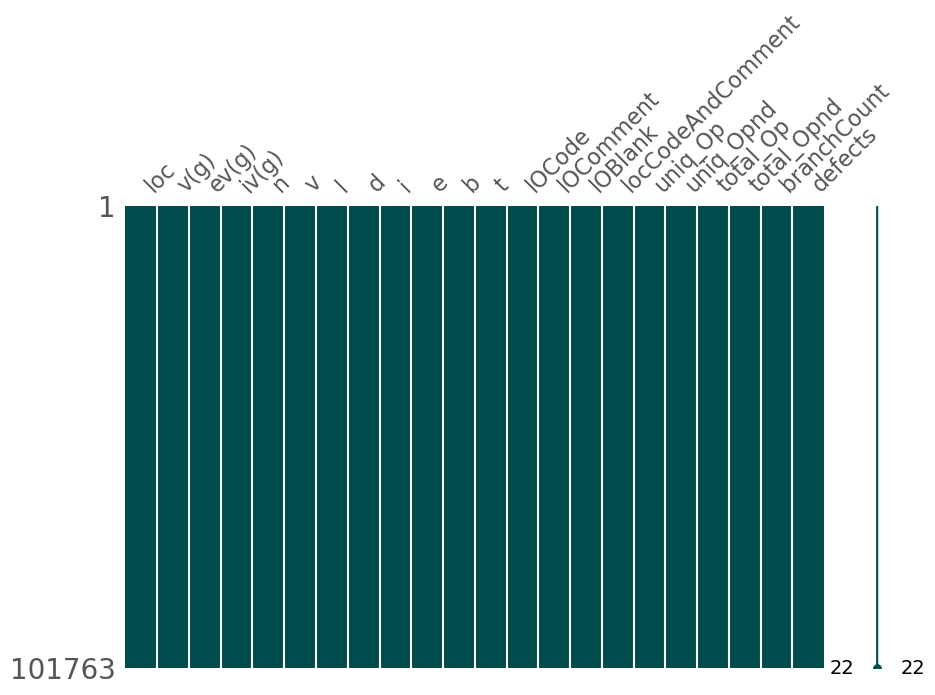

In [33]:
# 欠損値の有無を可視化する
msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3))

元々欠損値がないデータ

## データセットのプロット（分布）

### 密度関数（ヒストグラム）

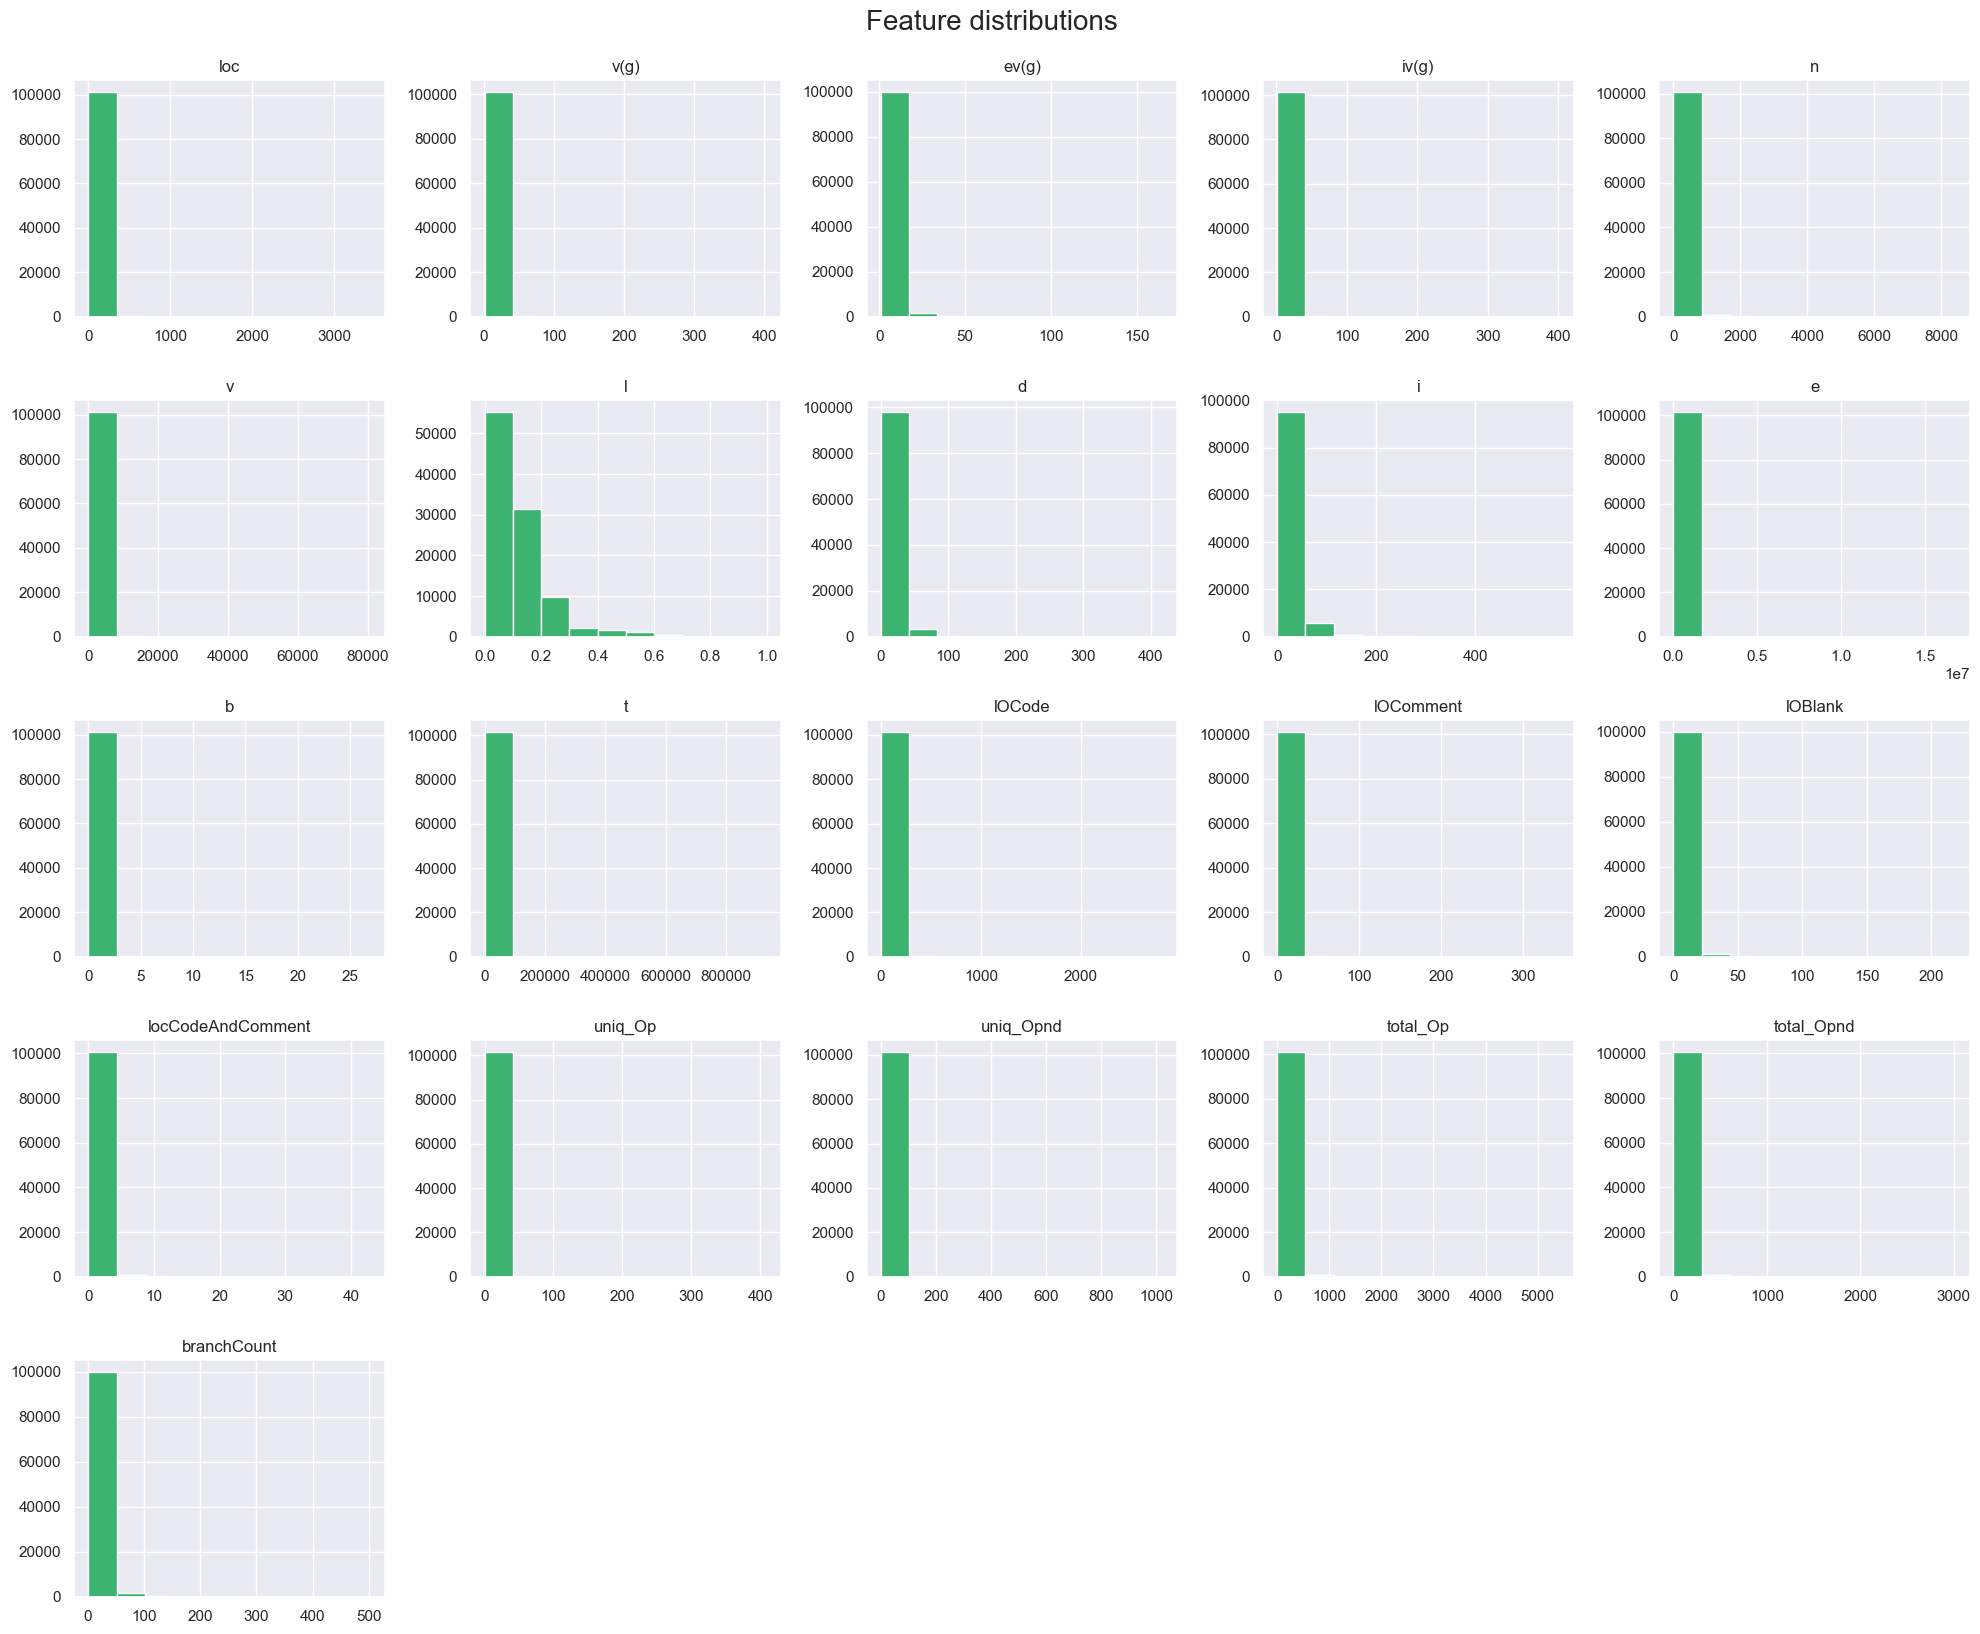

In [25]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

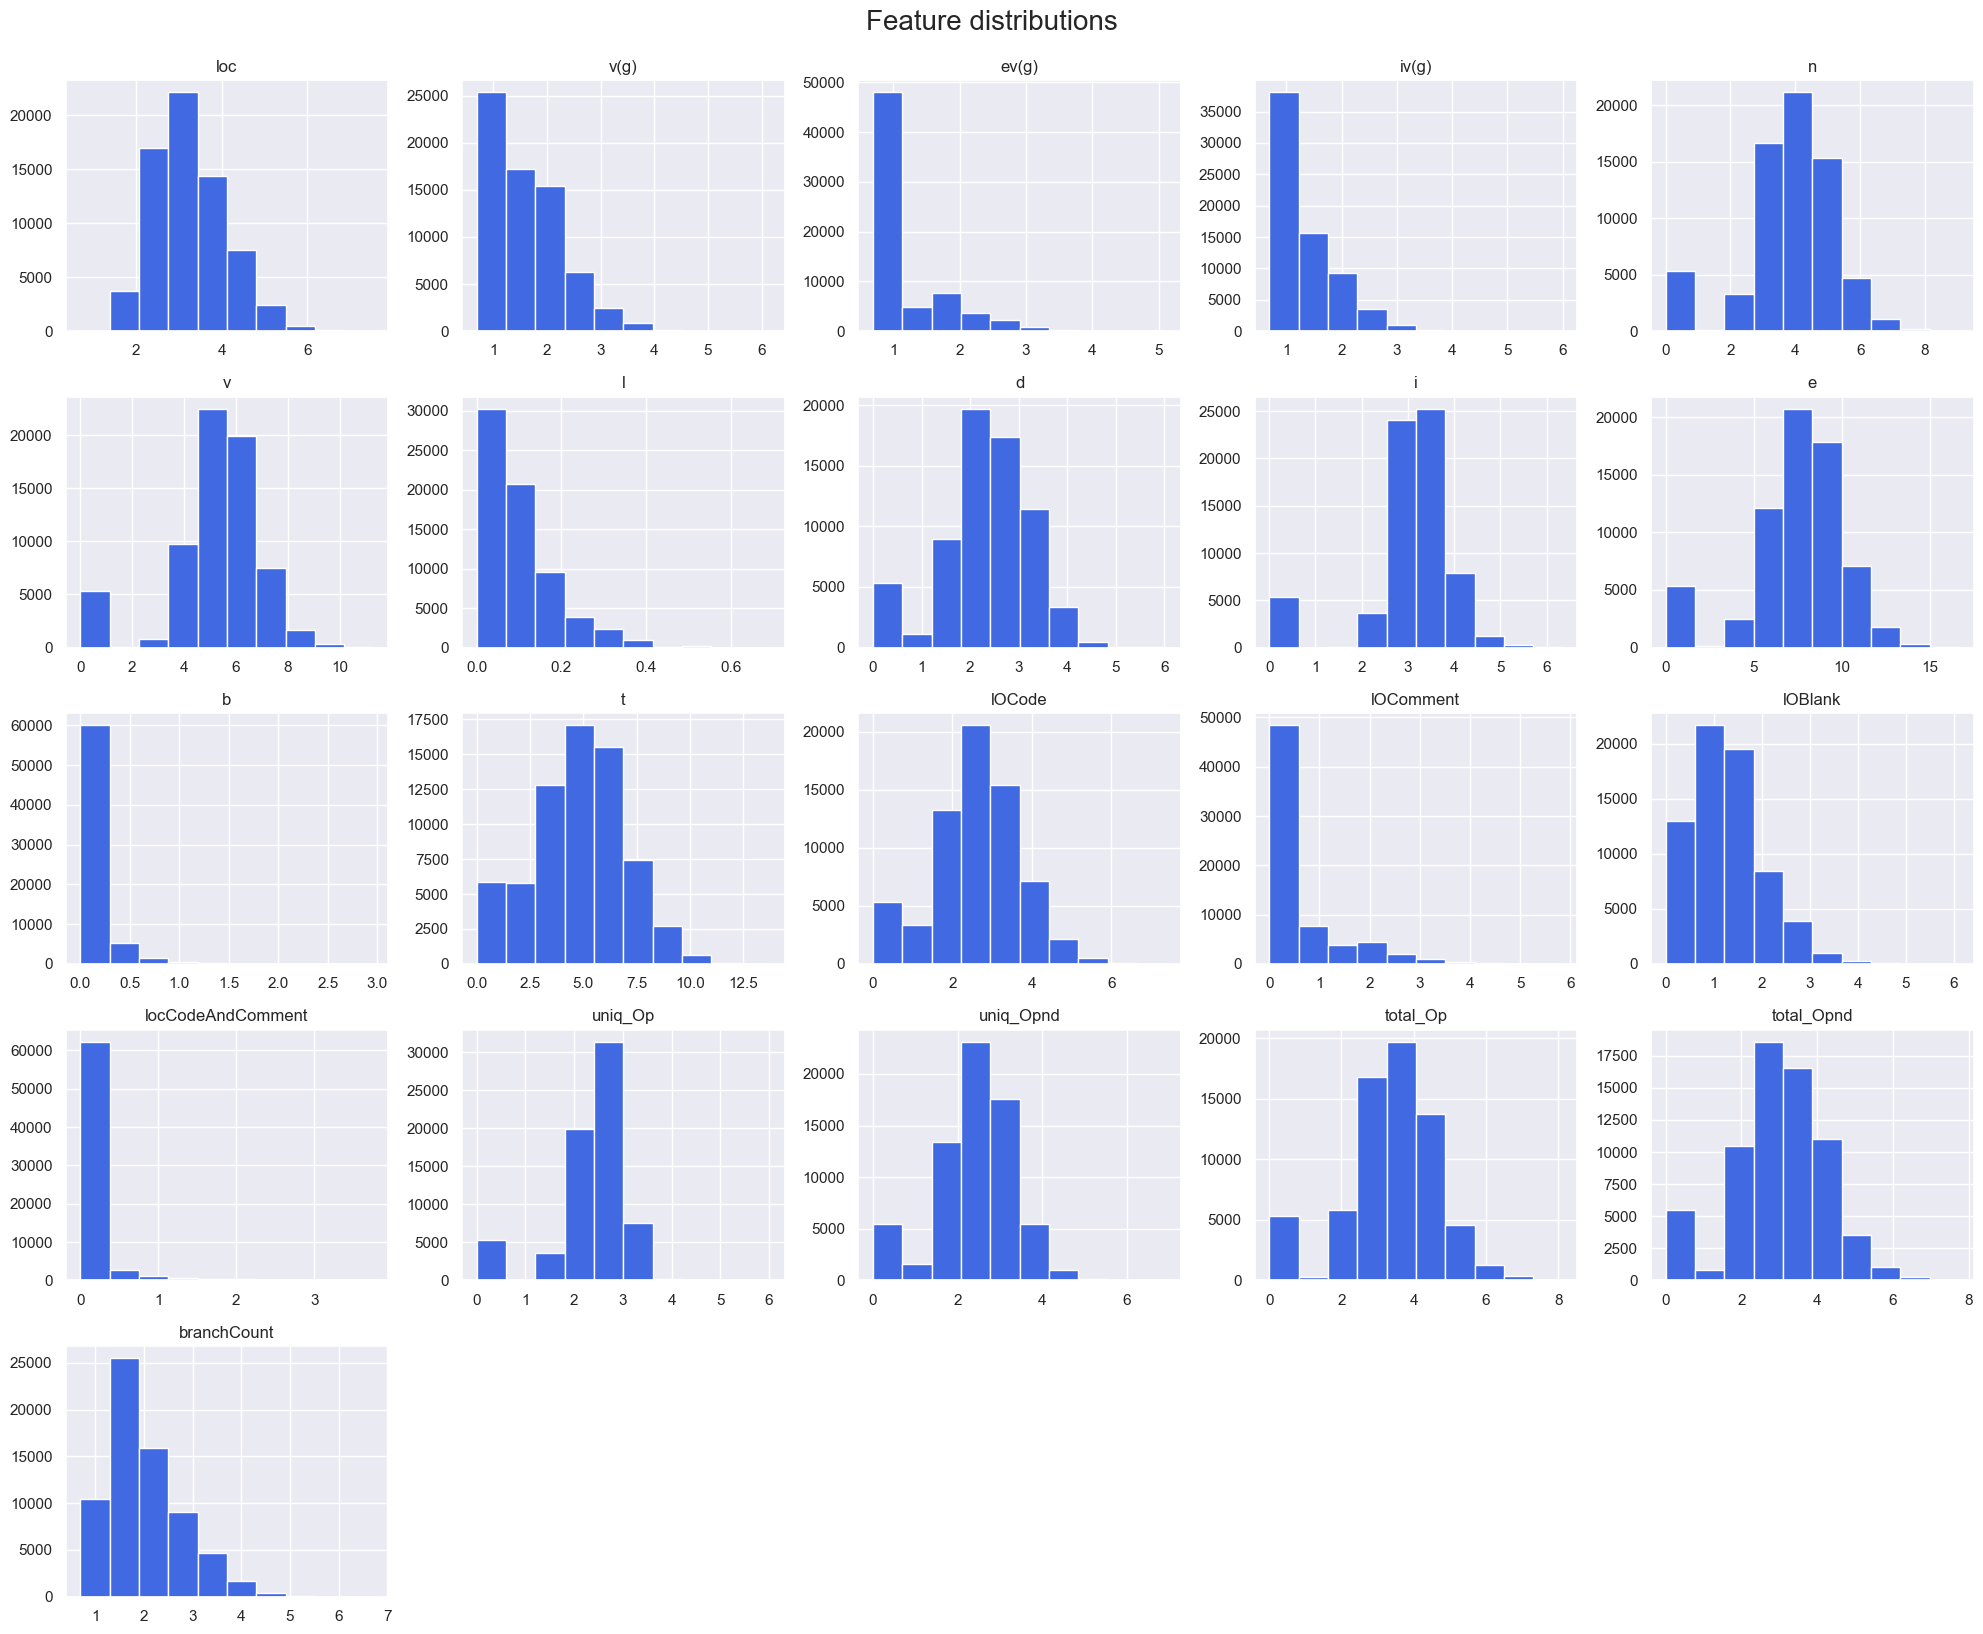

In [26]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

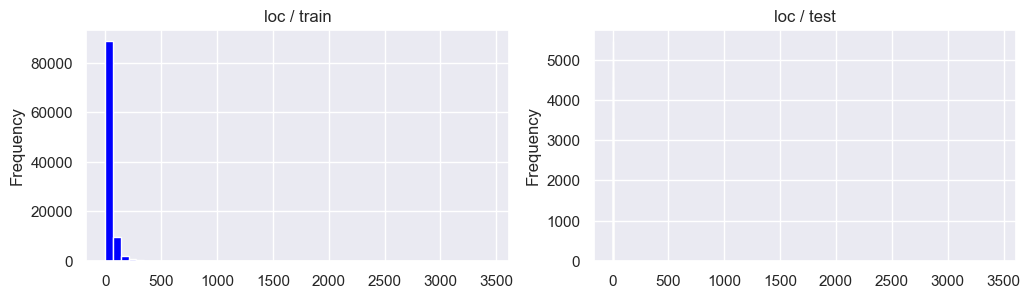

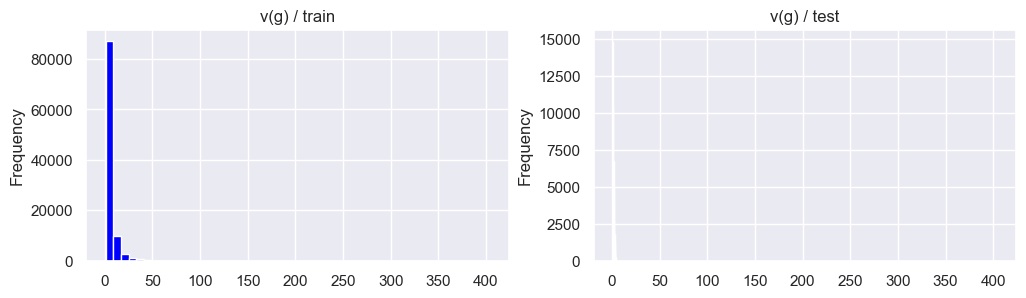

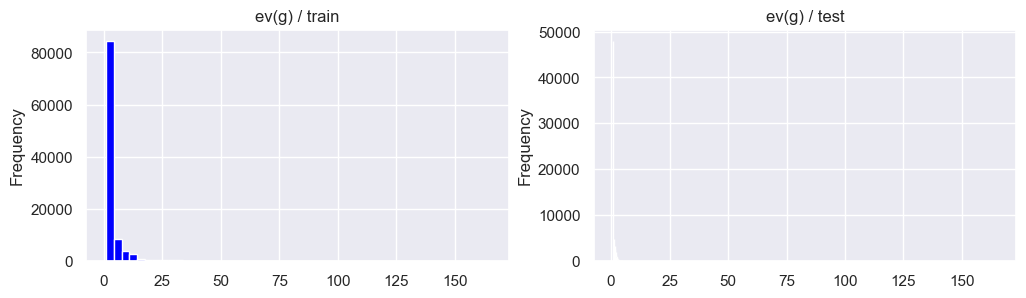

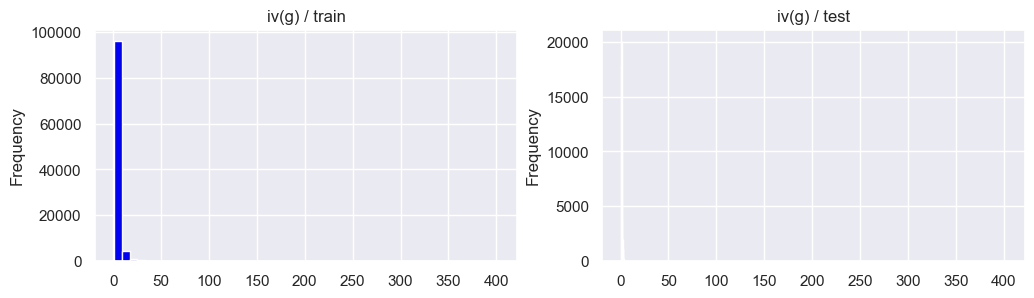

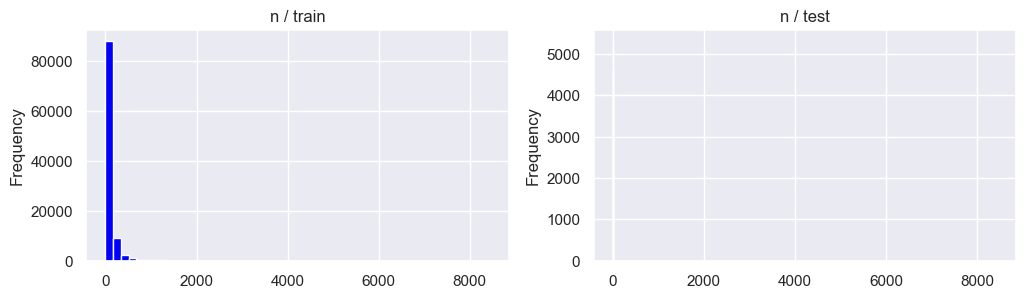

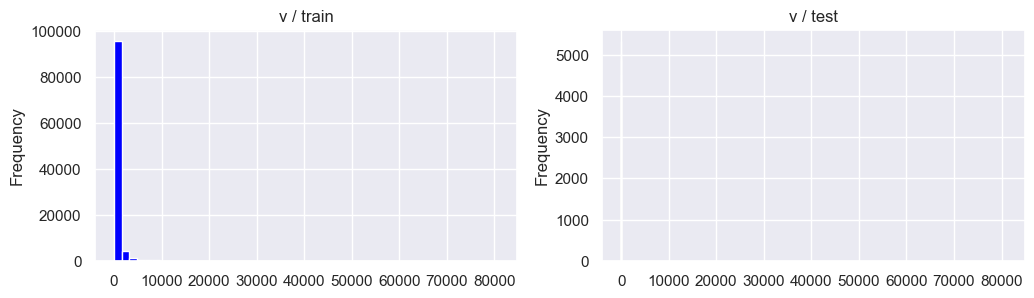

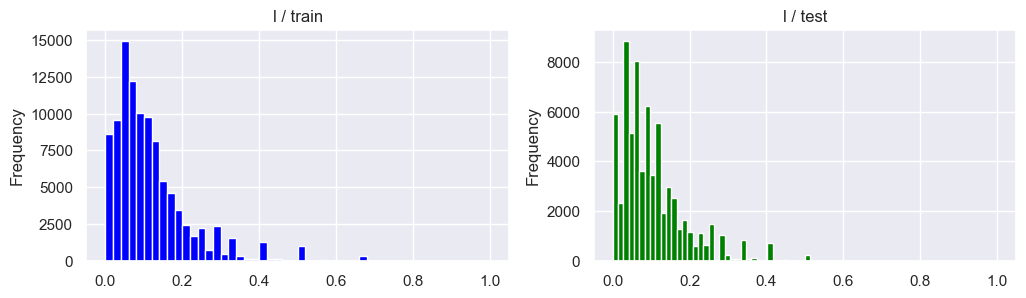

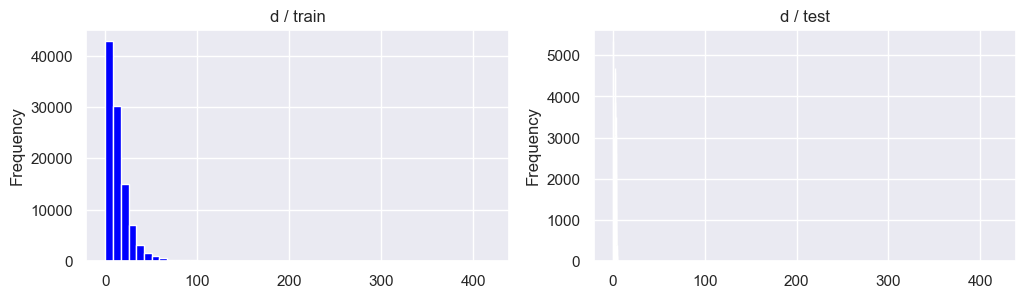

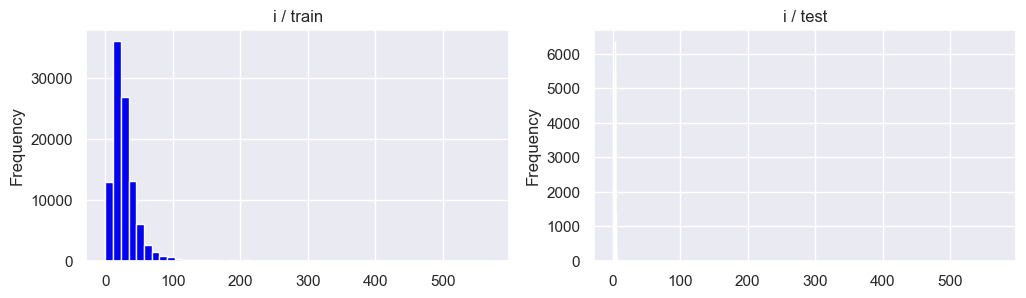

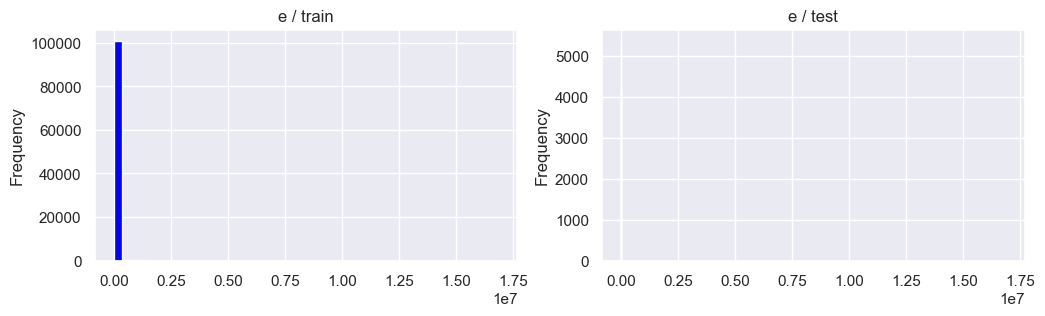

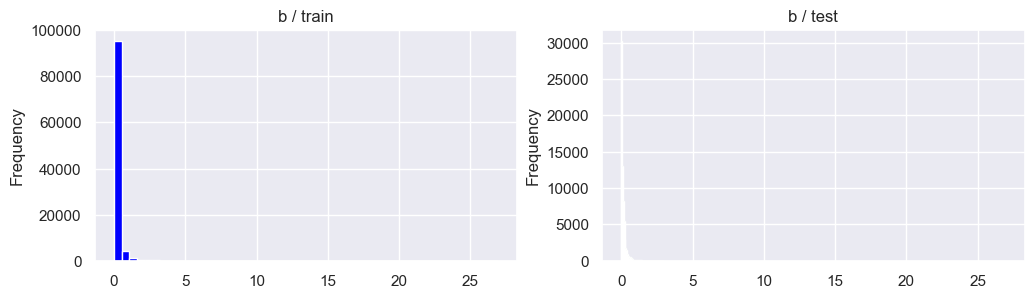

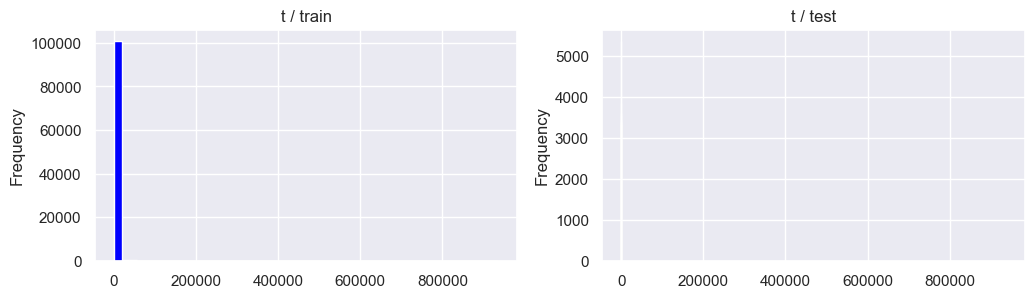

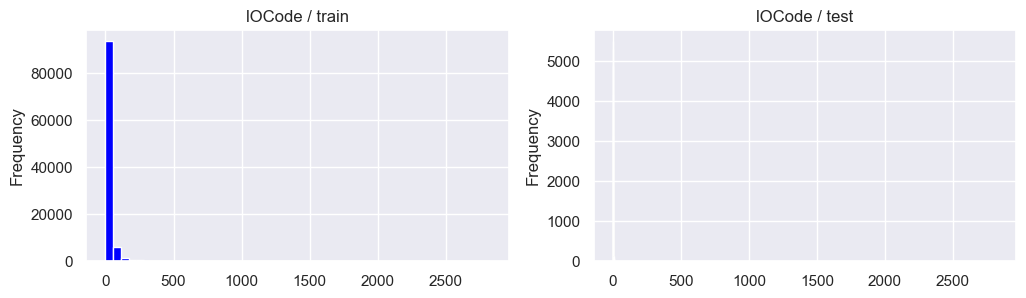

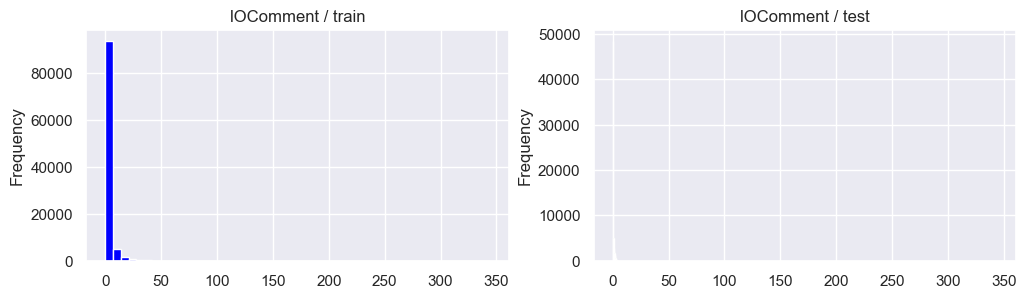

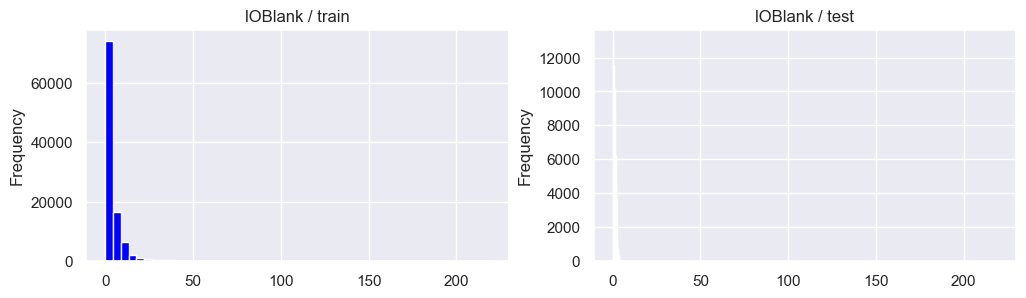

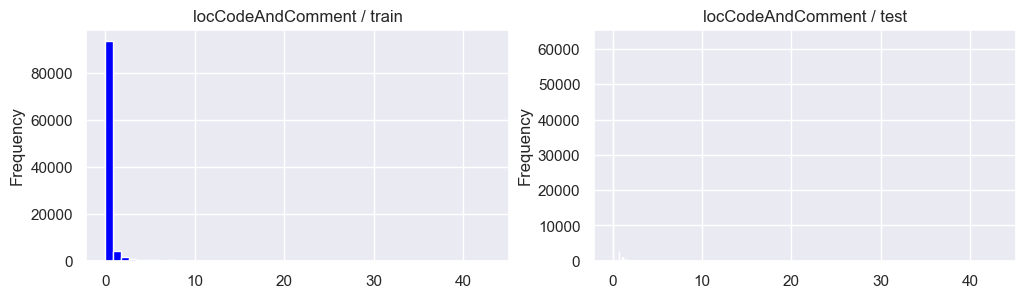

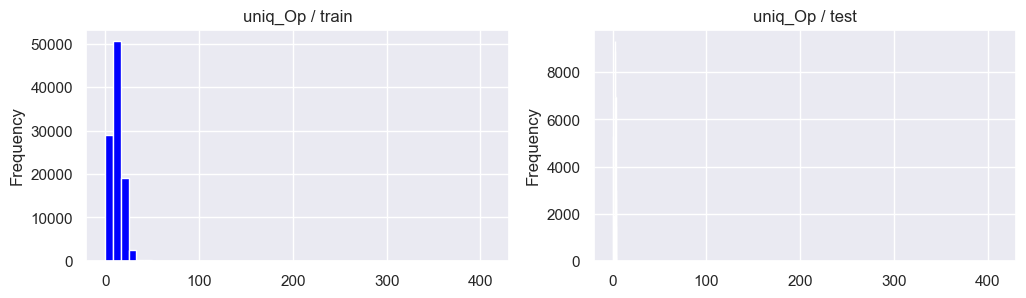

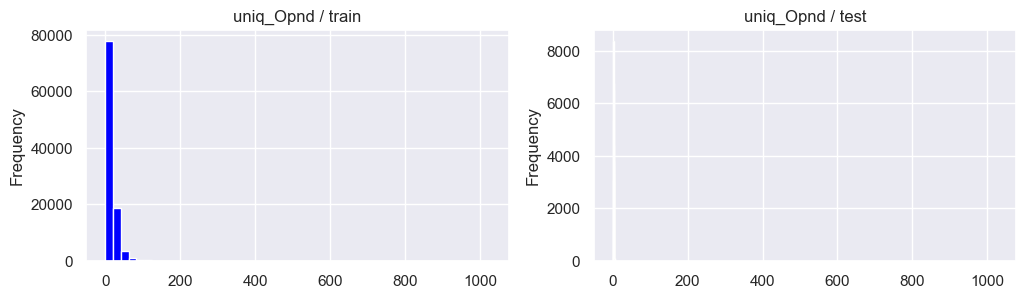

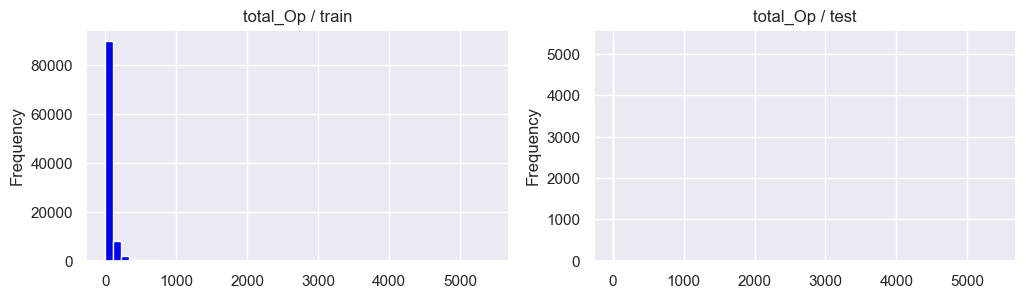

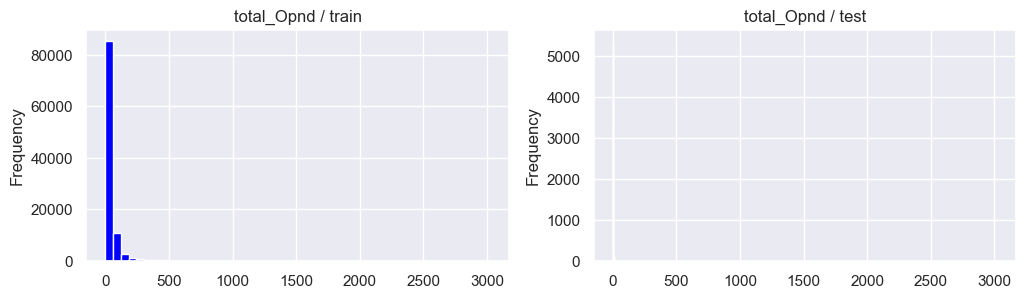

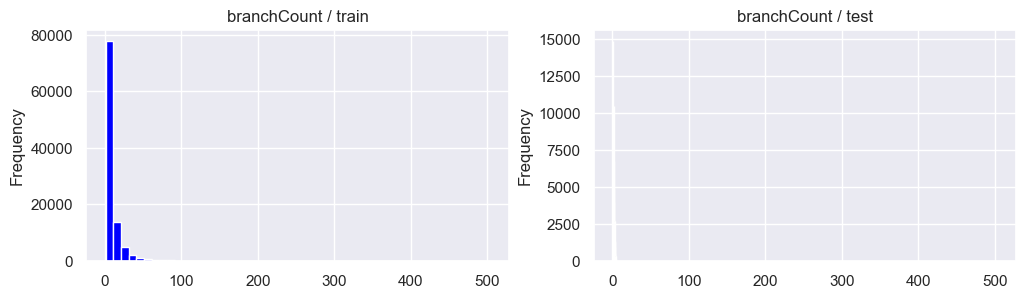

In [27]:
feature = train.columns.drop(['defects']).tolist() # 目的変数を指定する

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

#### データを対数変換する

- 21個の特徴量は全て正の値である
- ヒストグラムは左に偏っており、指数分布に類似している

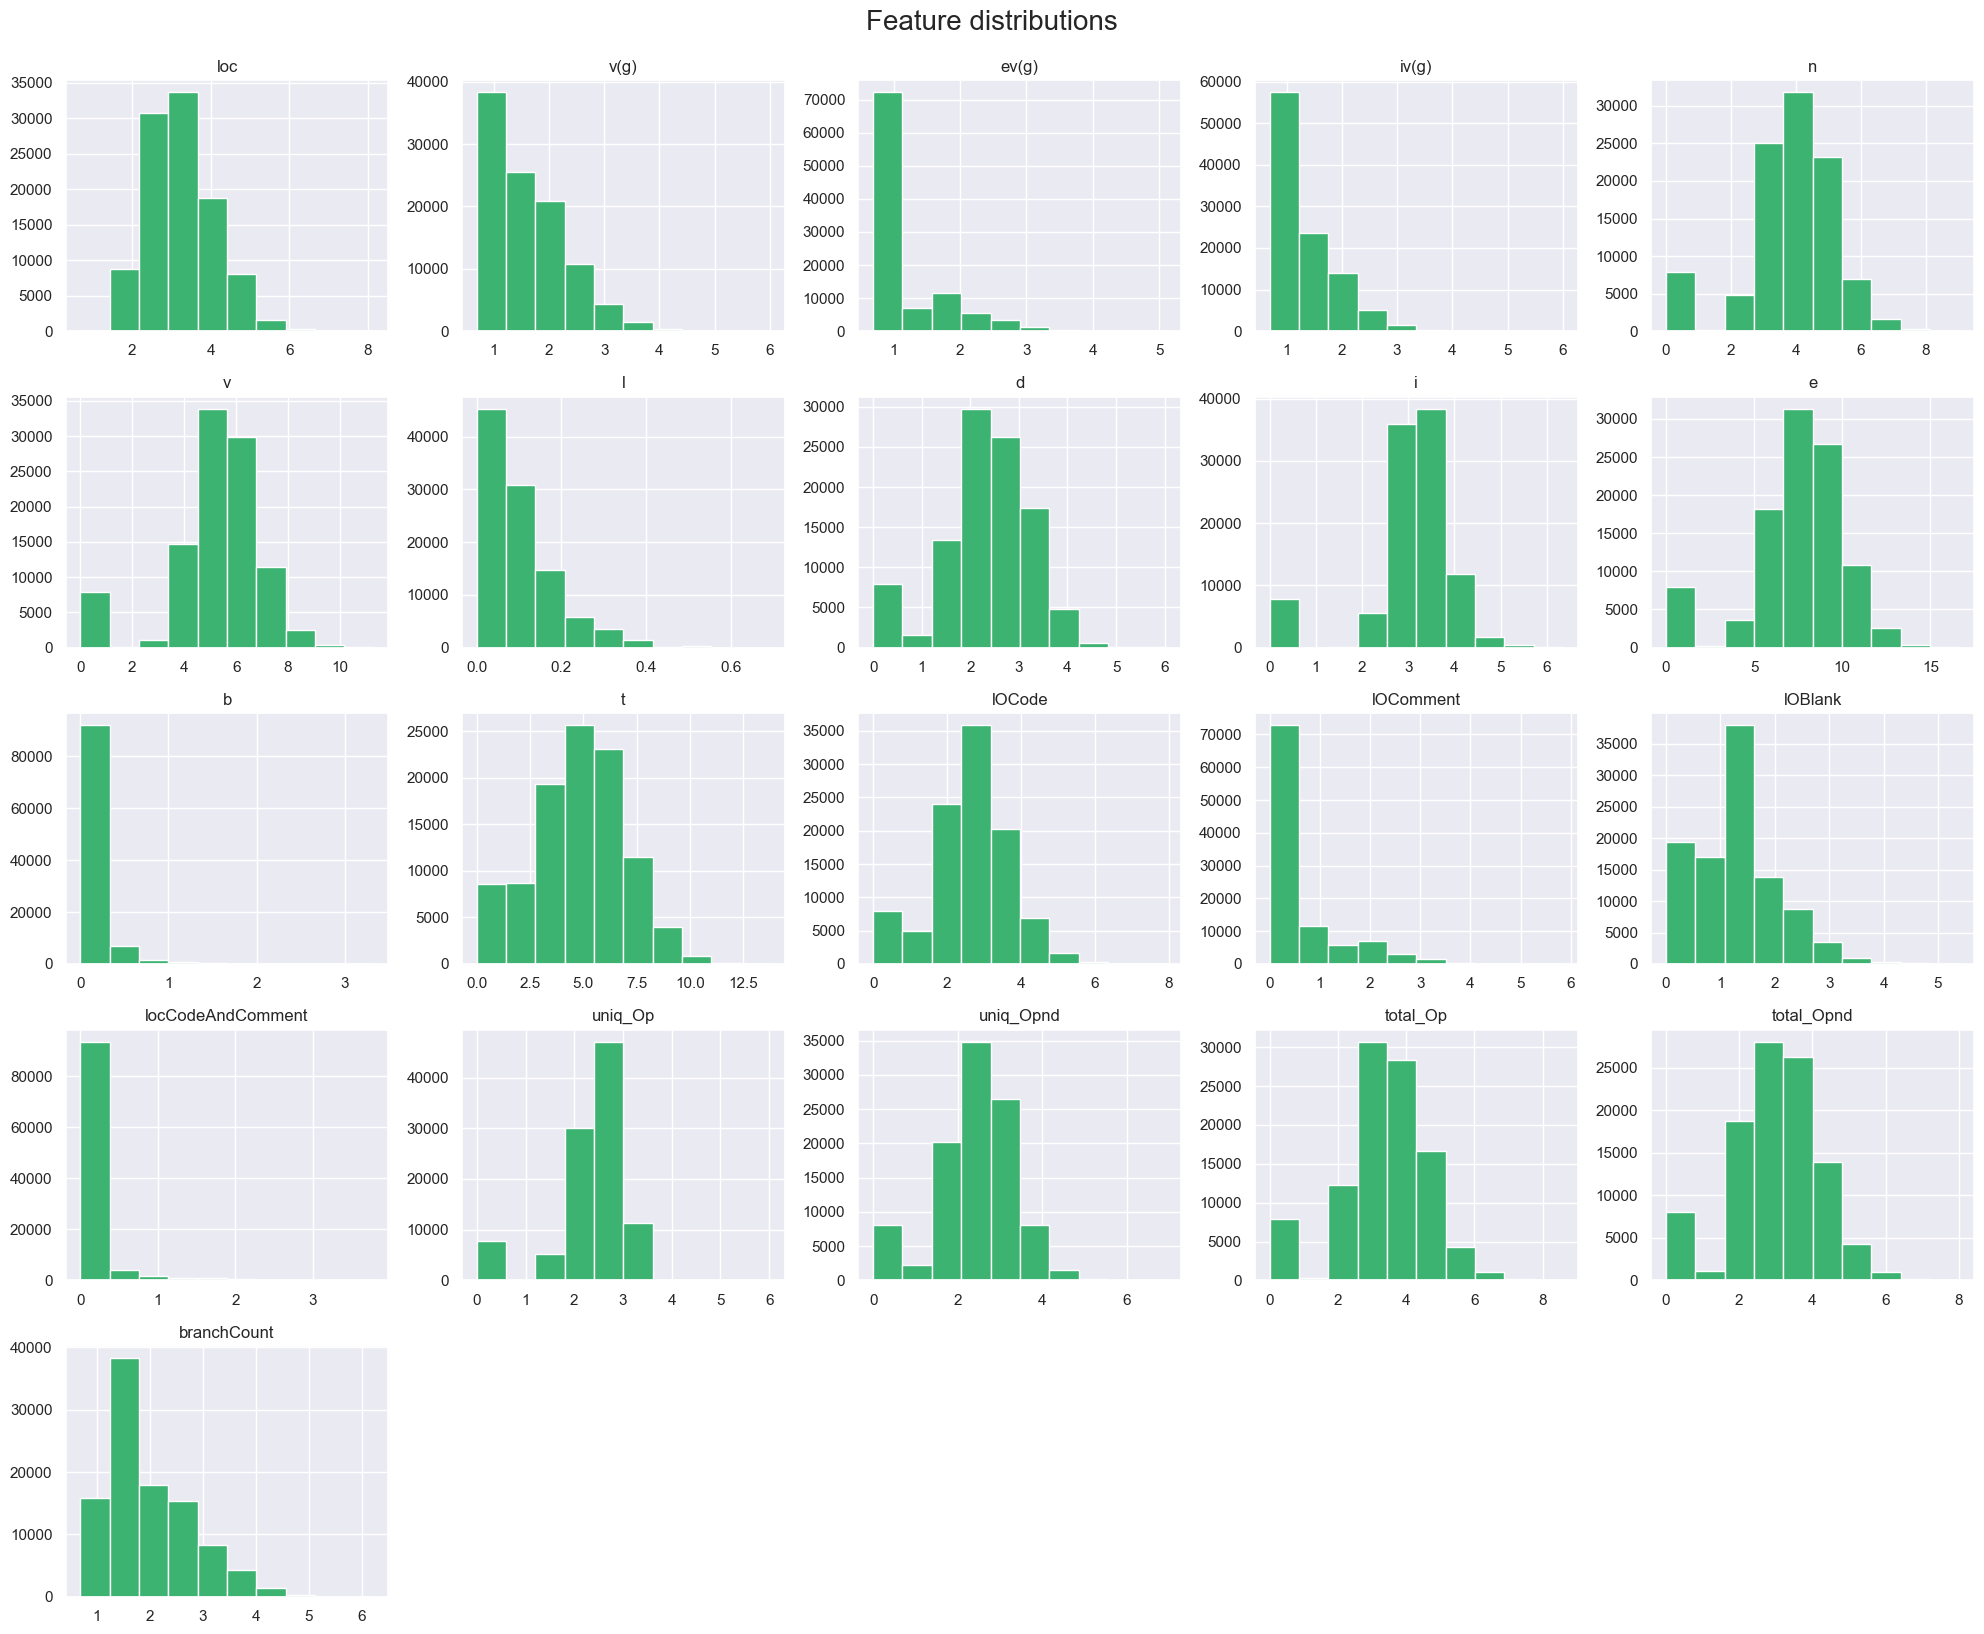

In [28]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train.drop(['defects'], axis=1) # 目的変数を指定する
y = target # 目的変数を指定する

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

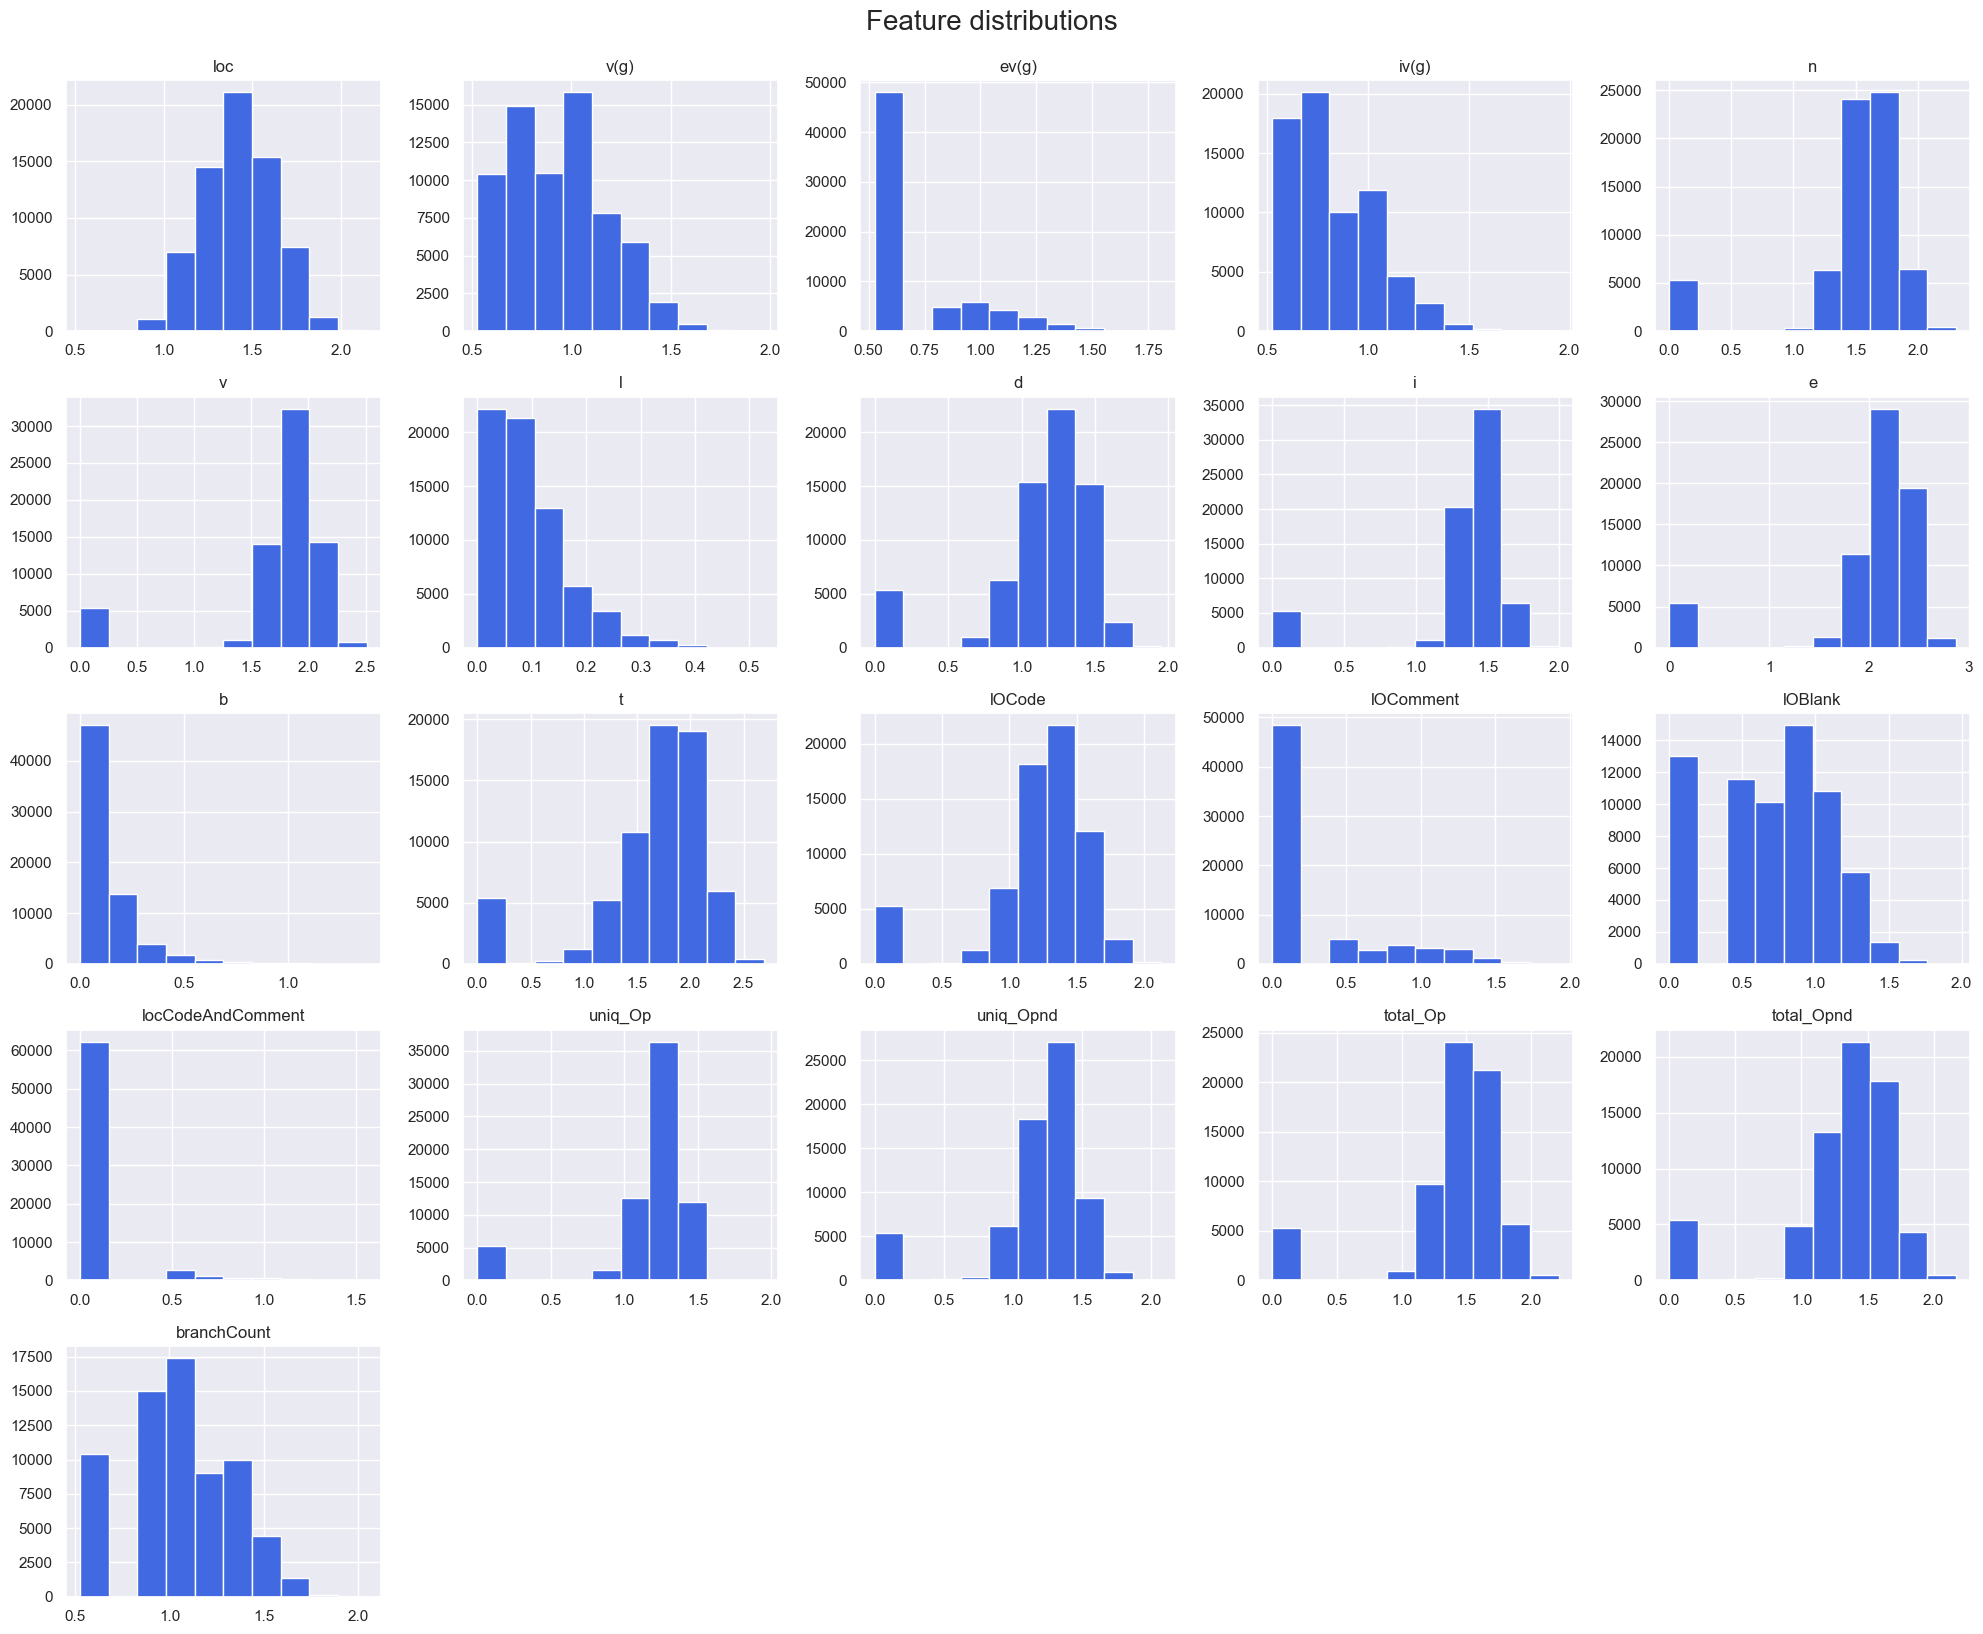

In [29]:
# テストデータも変換する
test_log = test
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

* 一部の説明変数において分布が確認しやすくなった
* このような分布の場合、`FunctionTransformer(np.log1p)`をパイプラインに前置することでデータを対数変換すると、多くのモデルが恩恵を受ける可能性がある

### 円グラフ：　目的変数

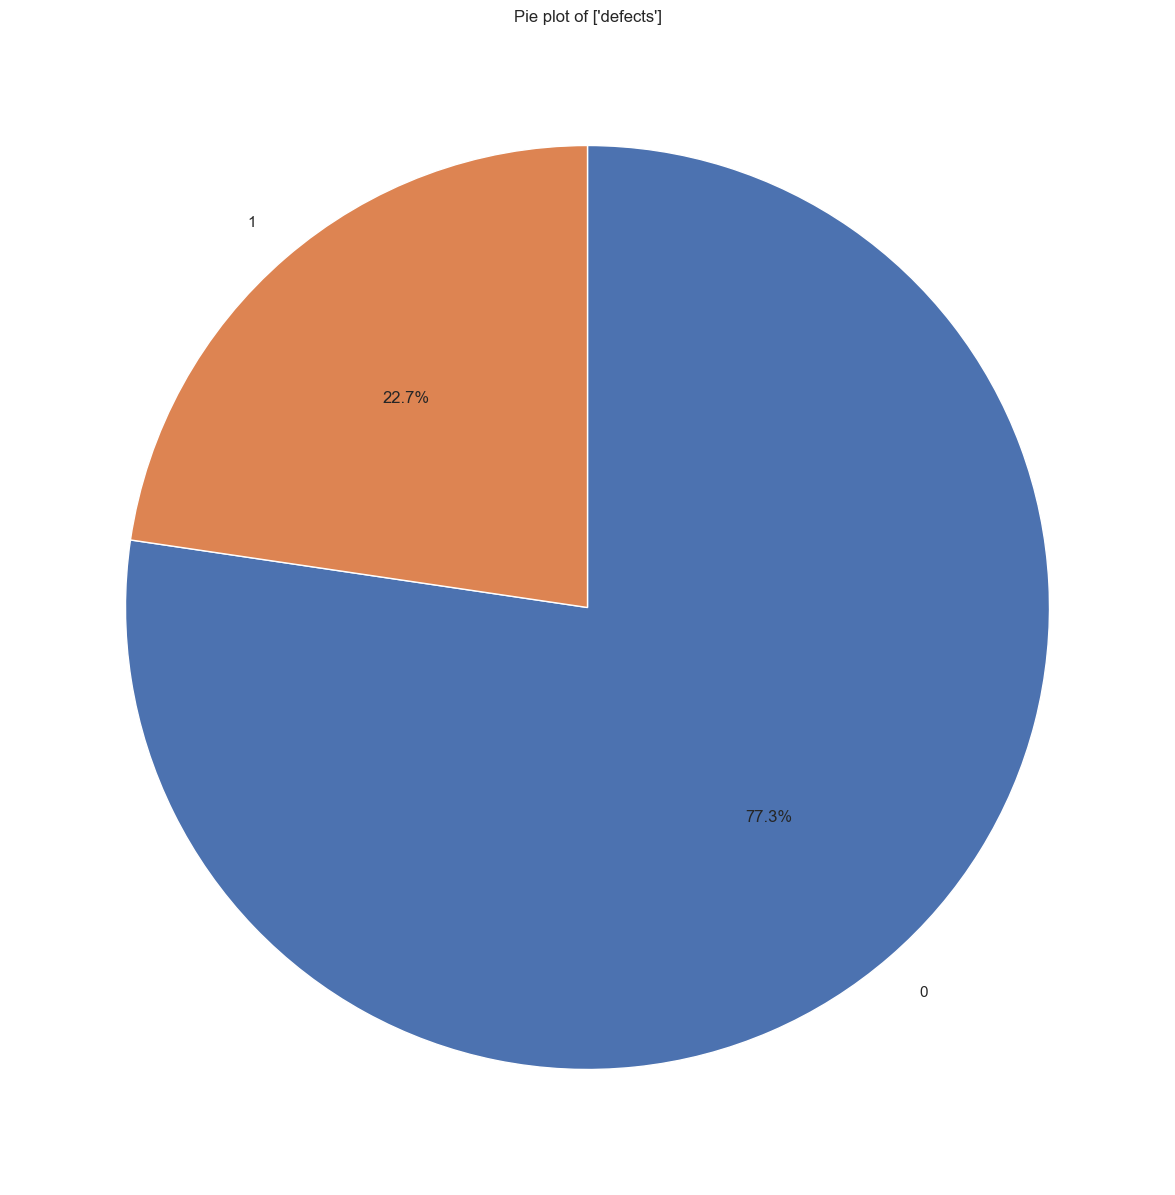

In [40]:
label_counts = target.value_counts()
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 15))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90,
        counterclock=False)
plt.title('Pie plot of ' + target_name)
plt.show()

#### 円グラフと棒グラフ（目的変数）

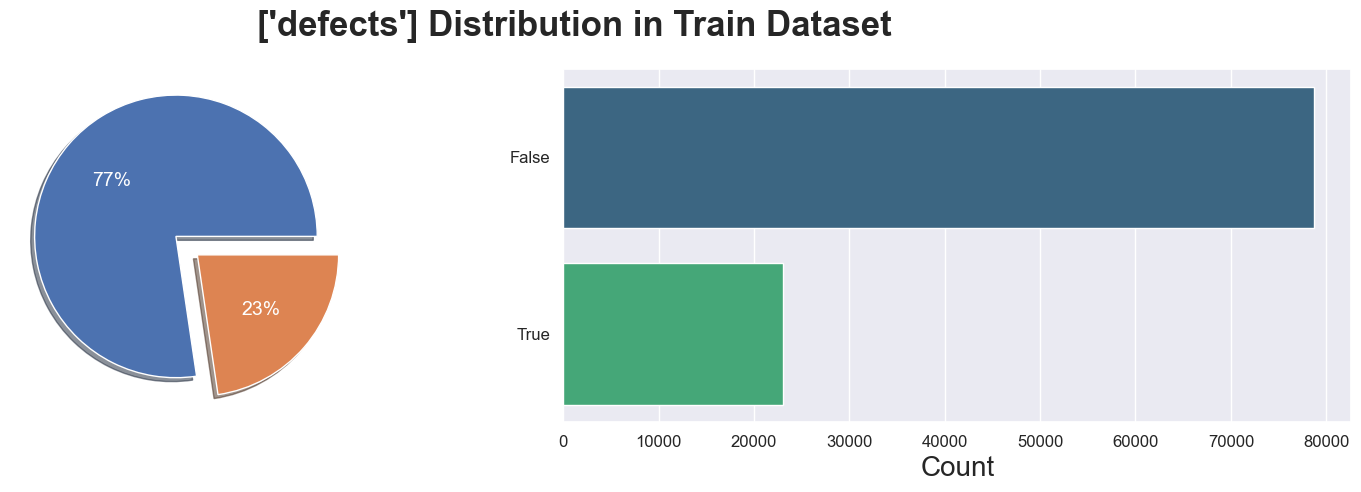

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    train['defects'].value_counts(),
    shadow=True,
    explode=[.1 for i in range(train.defects.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y='defects', ax=ax[1], palette='viridis', order=train['defects'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold') # target_name + 'Distribution in Train Dataset'にしようかな？
plt.tight_layout()

### 箱ひげ図

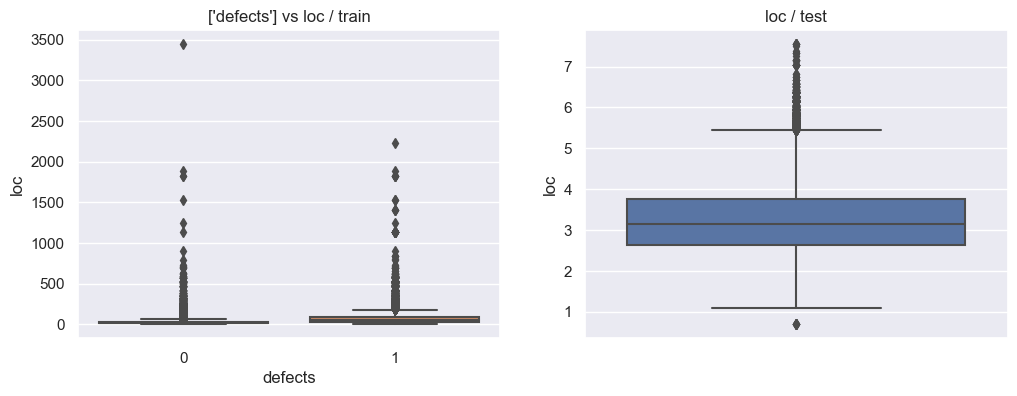

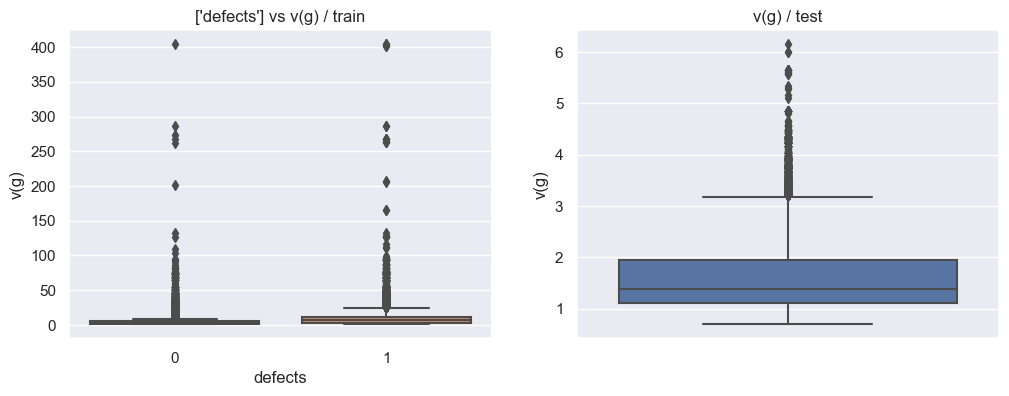

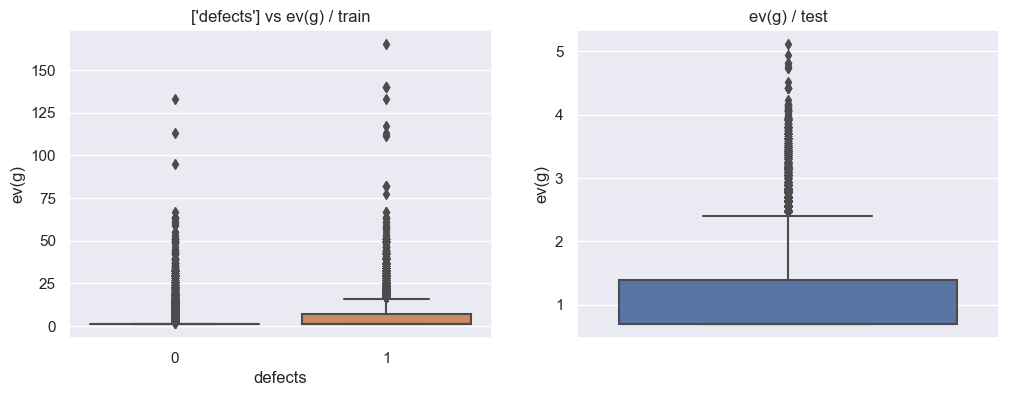

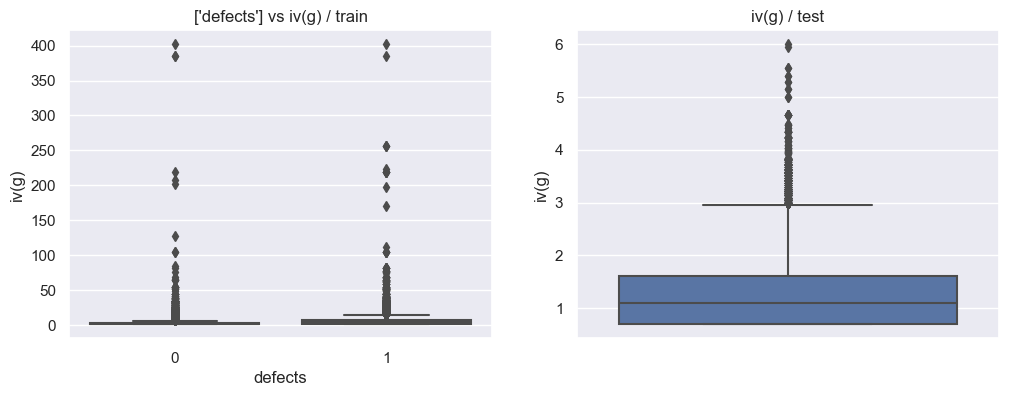

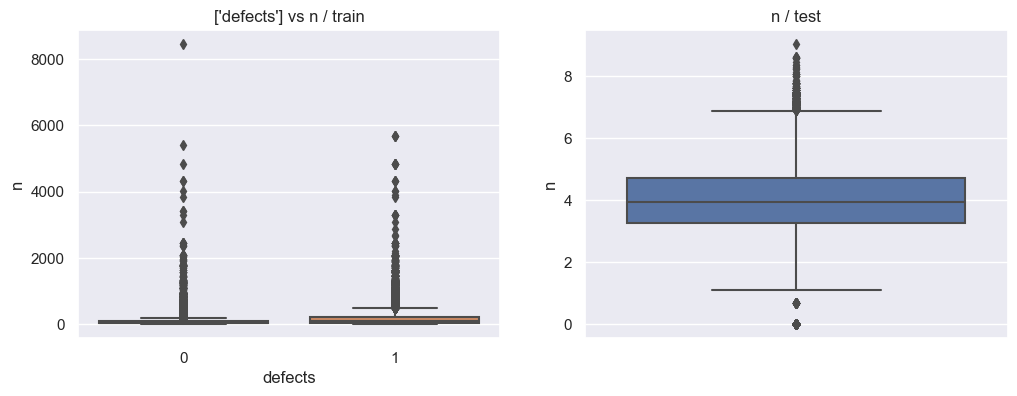

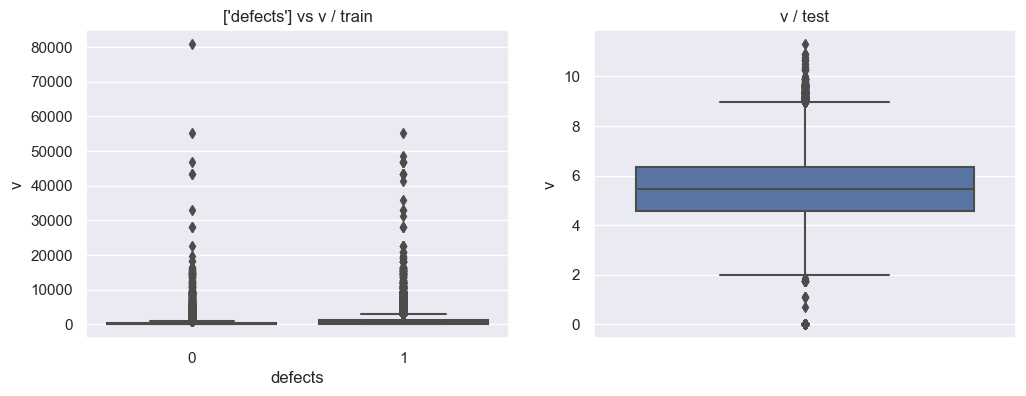

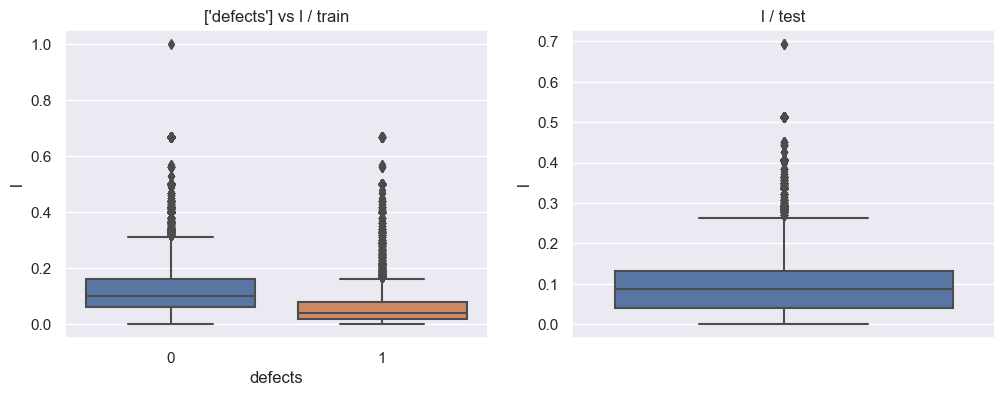

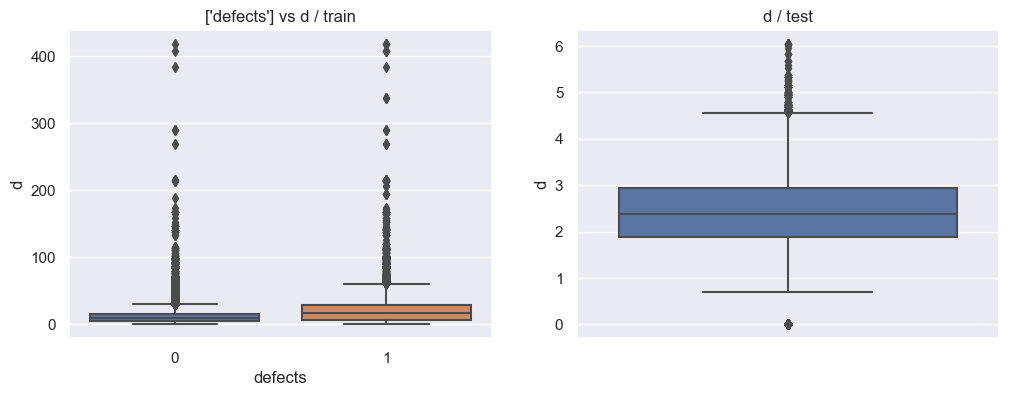

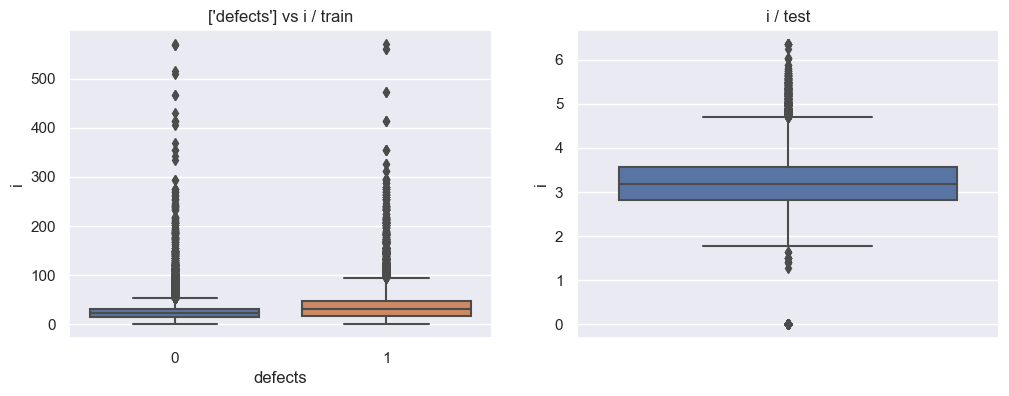

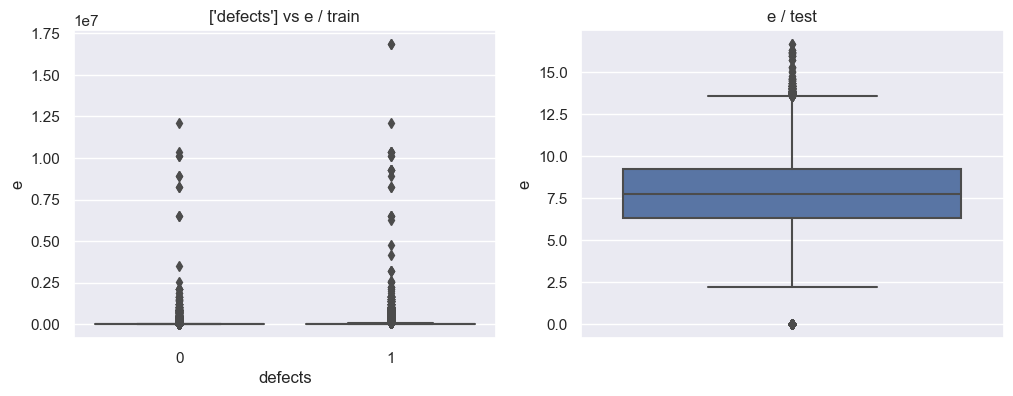

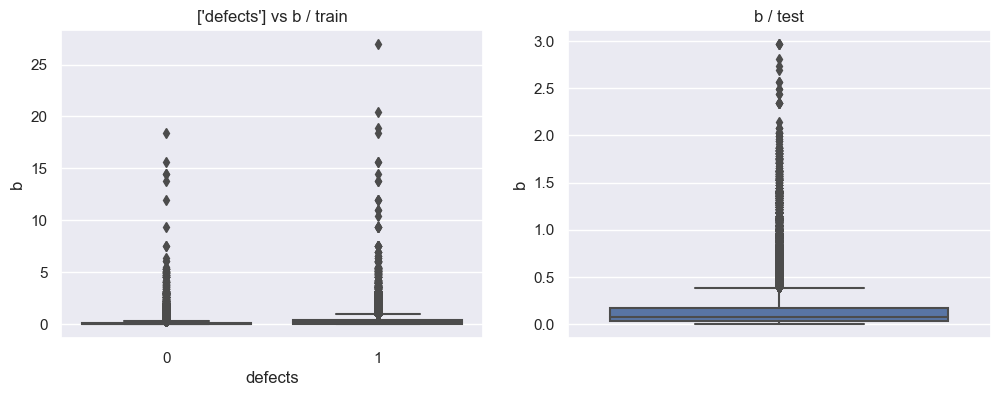

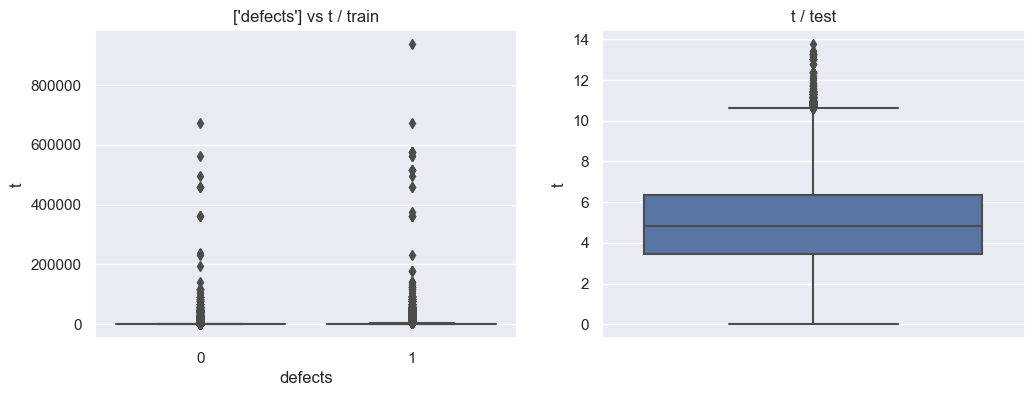

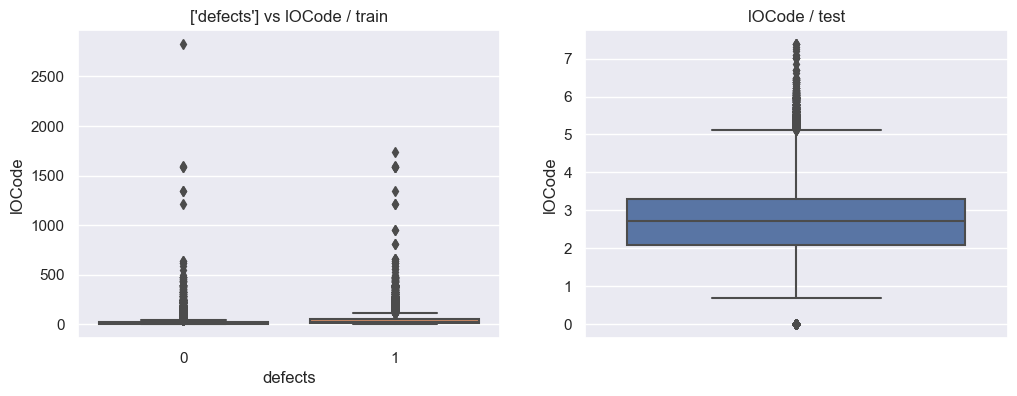

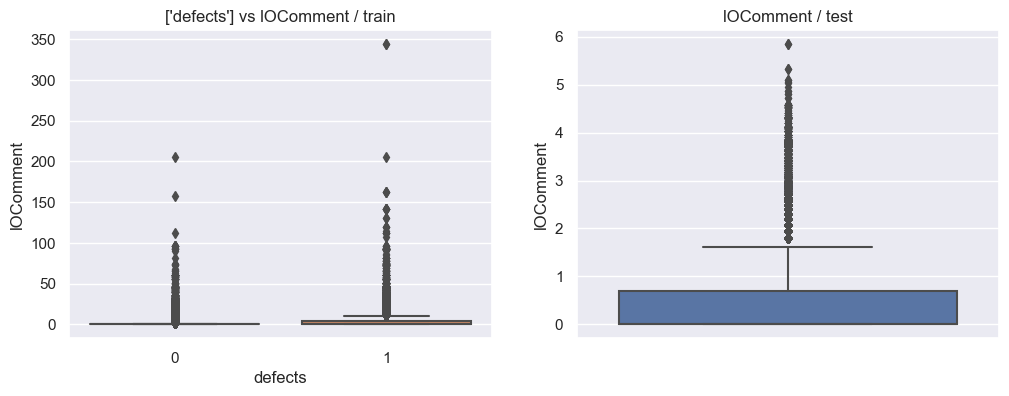

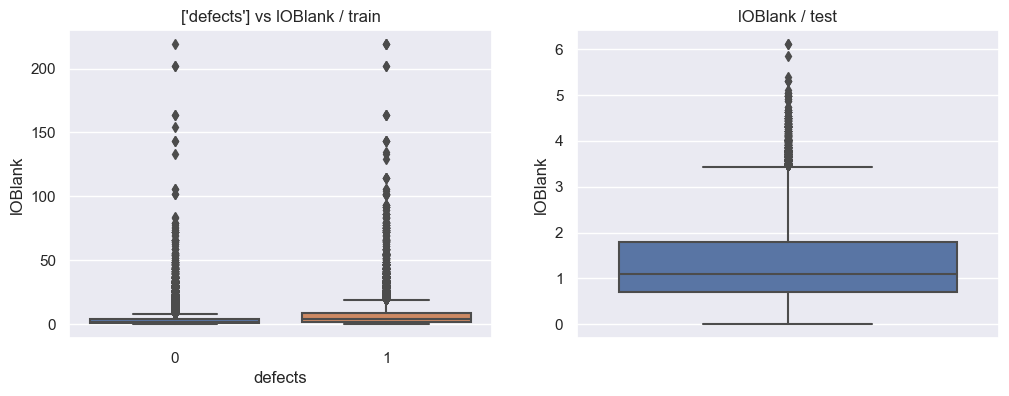

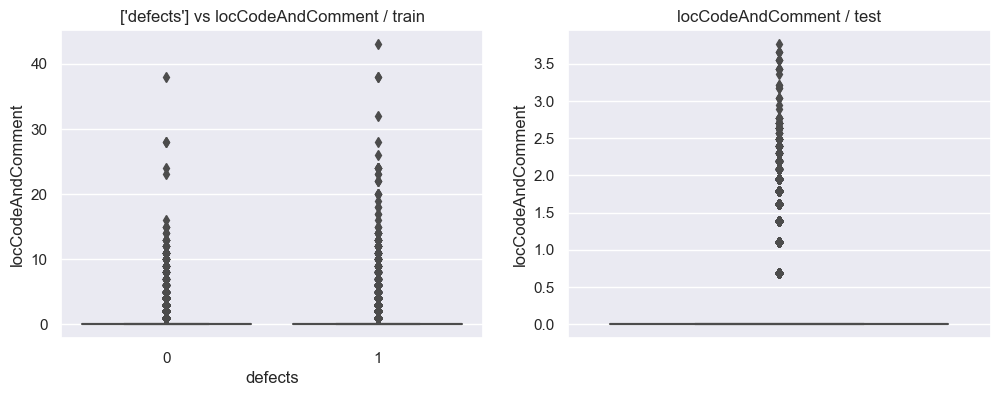

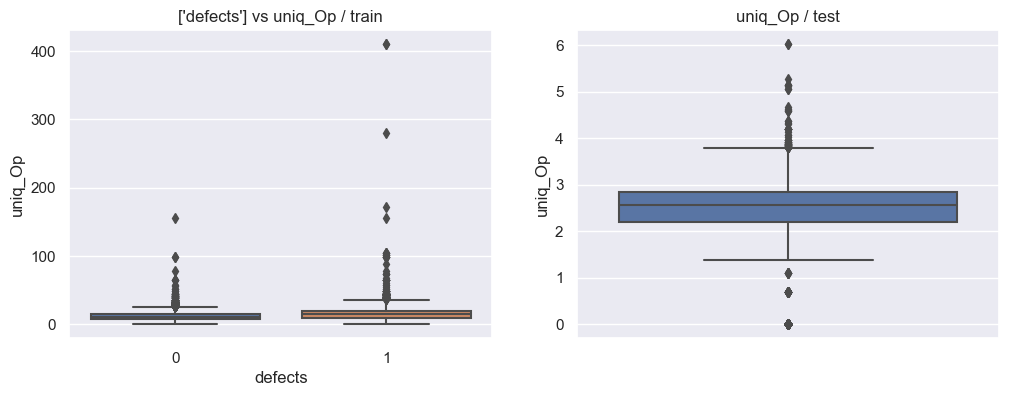

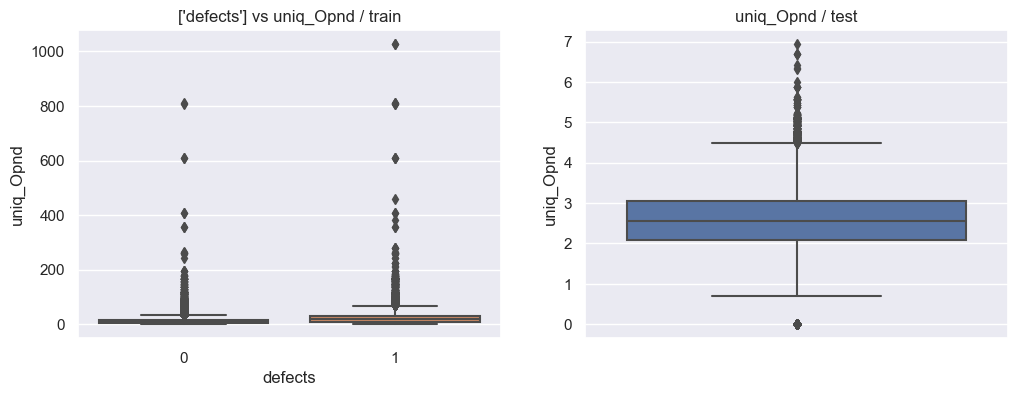

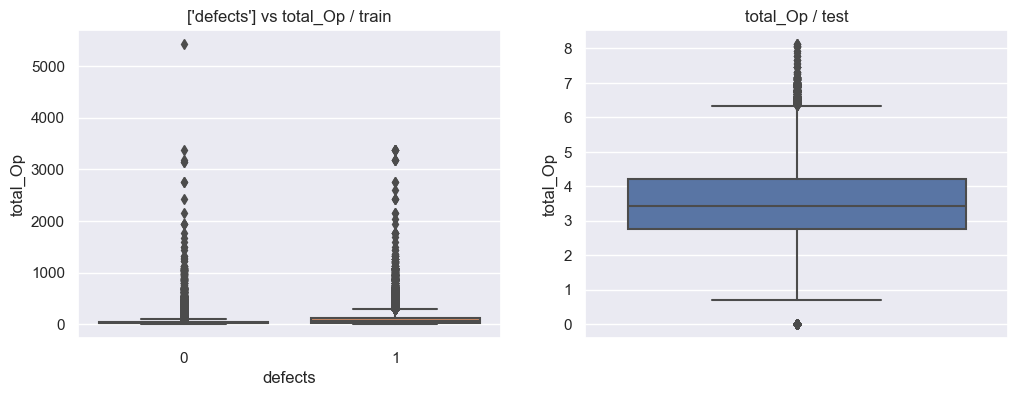

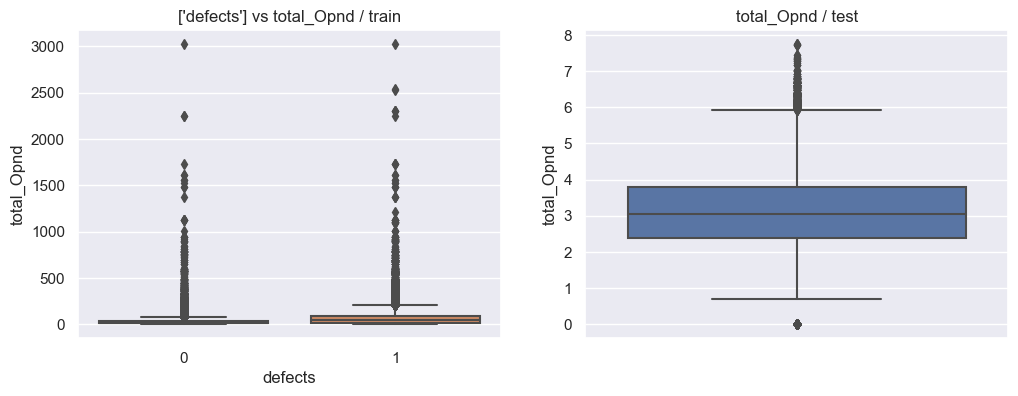

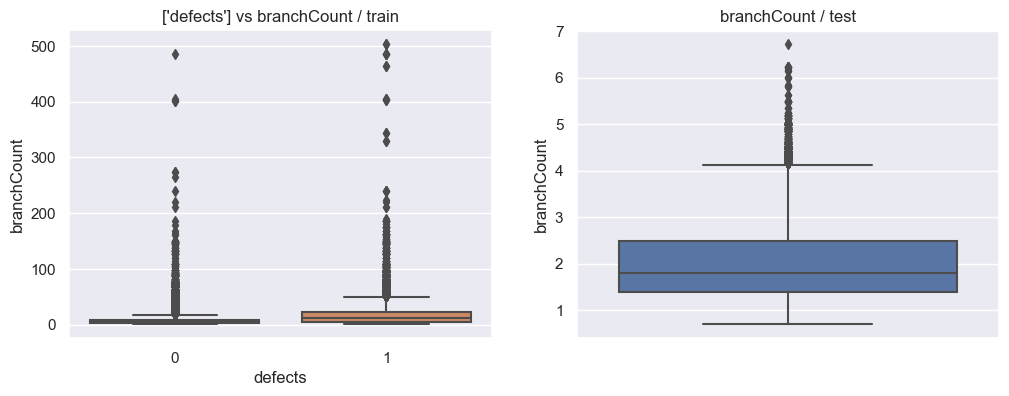

In [41]:
for feat in feature:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

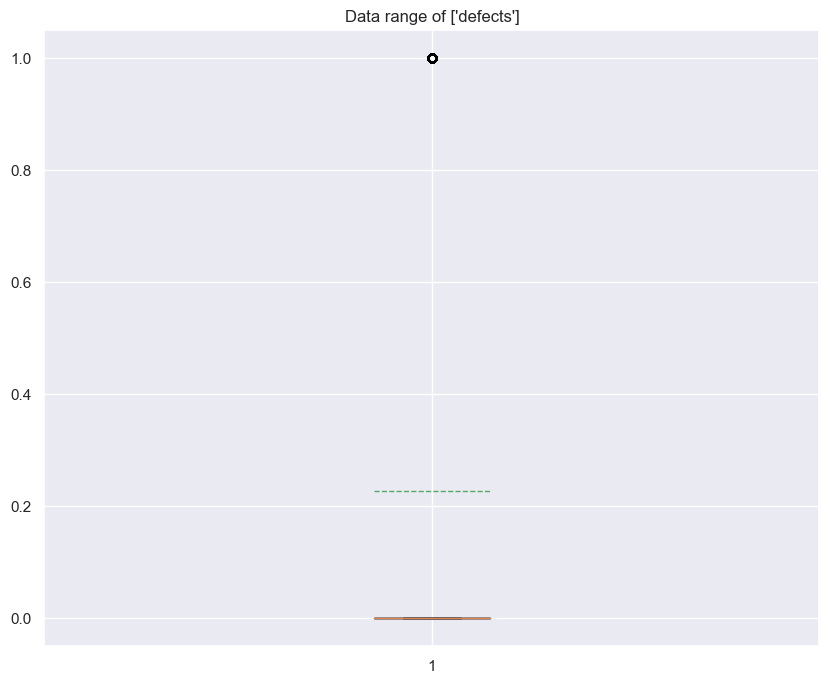

In [42]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

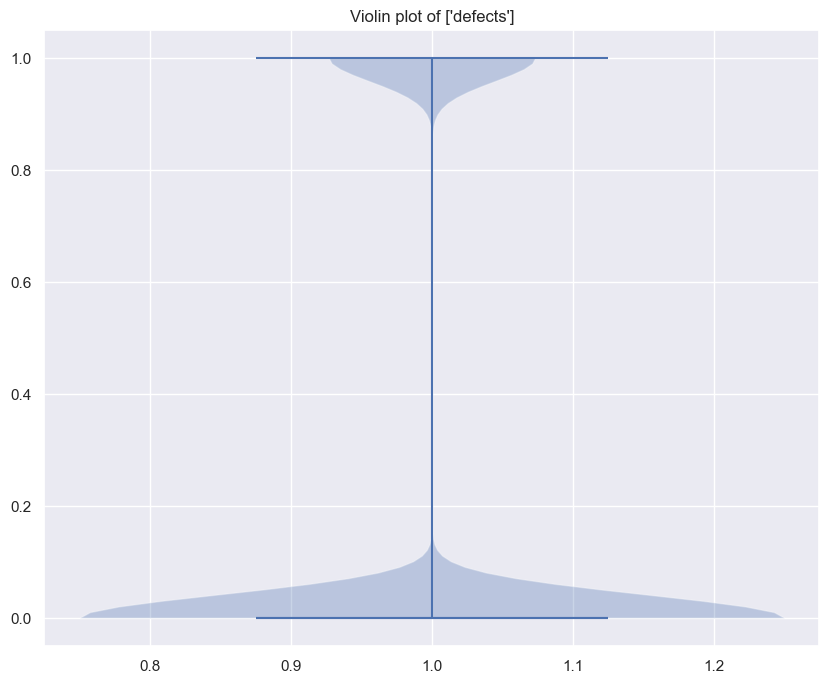

In [43]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

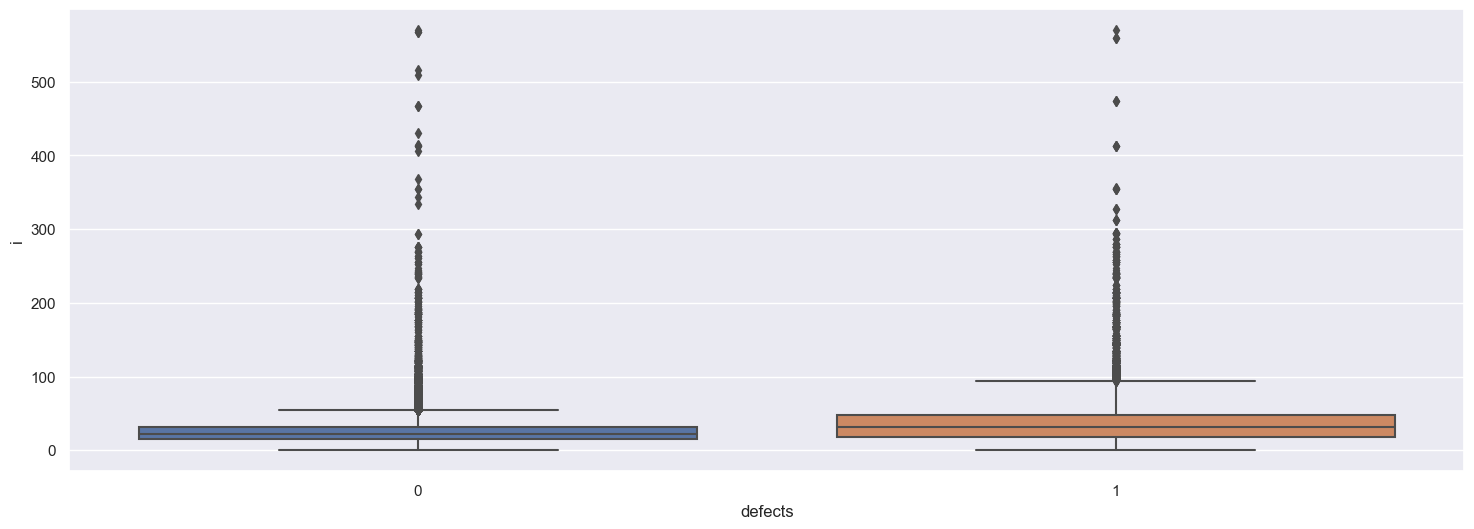

In [44]:
# 目的変数と'i'（最も特徴重要度の高い説明変数）との関係
train_most_important_value = 'i' # 説明変数を指定する
categorical_variate_corr = pd.concat([target, train[train_most_important_value]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=target, y=train_most_important_value, data=categorical_variate_corr)
fig.axis();

pd.melt()は容量が頭おかしいくらい食われるから今回は使用しない

### 特徴量の重要度評価

                   importance
loc                  0.273385
i                    0.071989
d                    0.053248
v                    0.052177
total_Op             0.043724
iv(g)                0.043218
total_Opnd           0.042813
lOCode               0.042784
e                    0.041320
t                    0.041061
n                    0.037793
uniq_Opnd            0.037657
uniq_Op              0.035412
ev(g)                0.034578
branchCount          0.031397
lOBlank              0.030468
v(g)                 0.028589
lOComment            0.023841
l                    0.011950
b                    0.011861
locCodeAndComment    0.010735
CPU times: user 2min 57s, sys: 3.9 s, total: 3min 1s
Wall time: 4min 1s


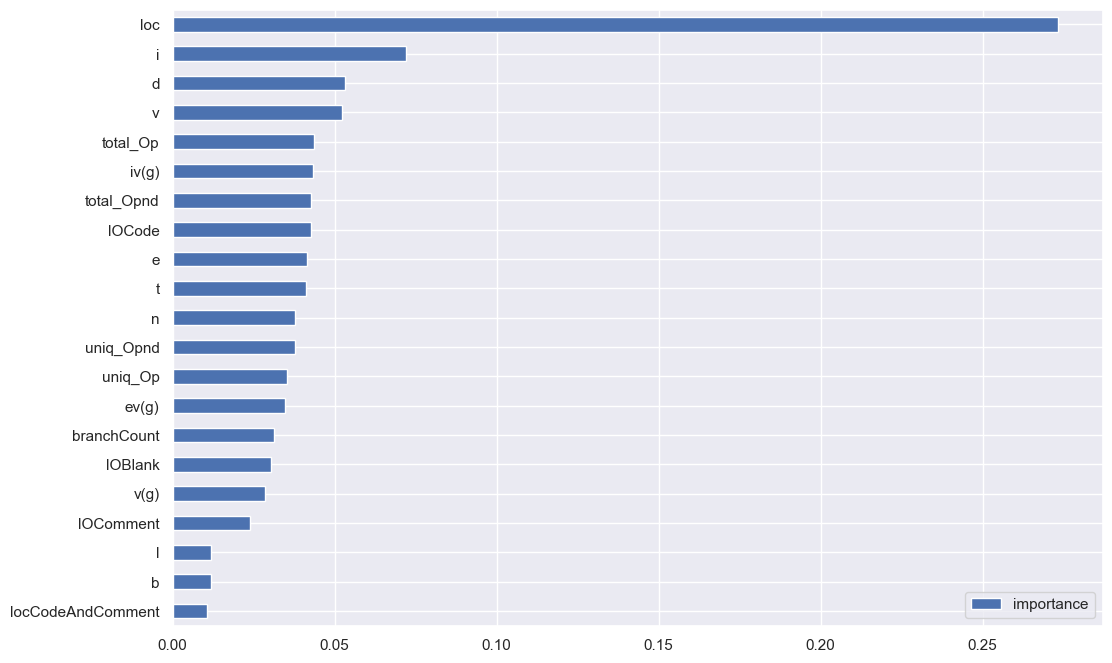

In [35]:
%%time

best_forest = RandomForestRegressor(
    random_state=42,
)

best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='b')
print(feature_importance.sort_values(ascending=False, by='importance'))

調べた結果を書く
* 'loc', 'i'の重要度が特に高い
* 'l', 'b'が低い

### 相関（ヒートマップ）

<Axes: >

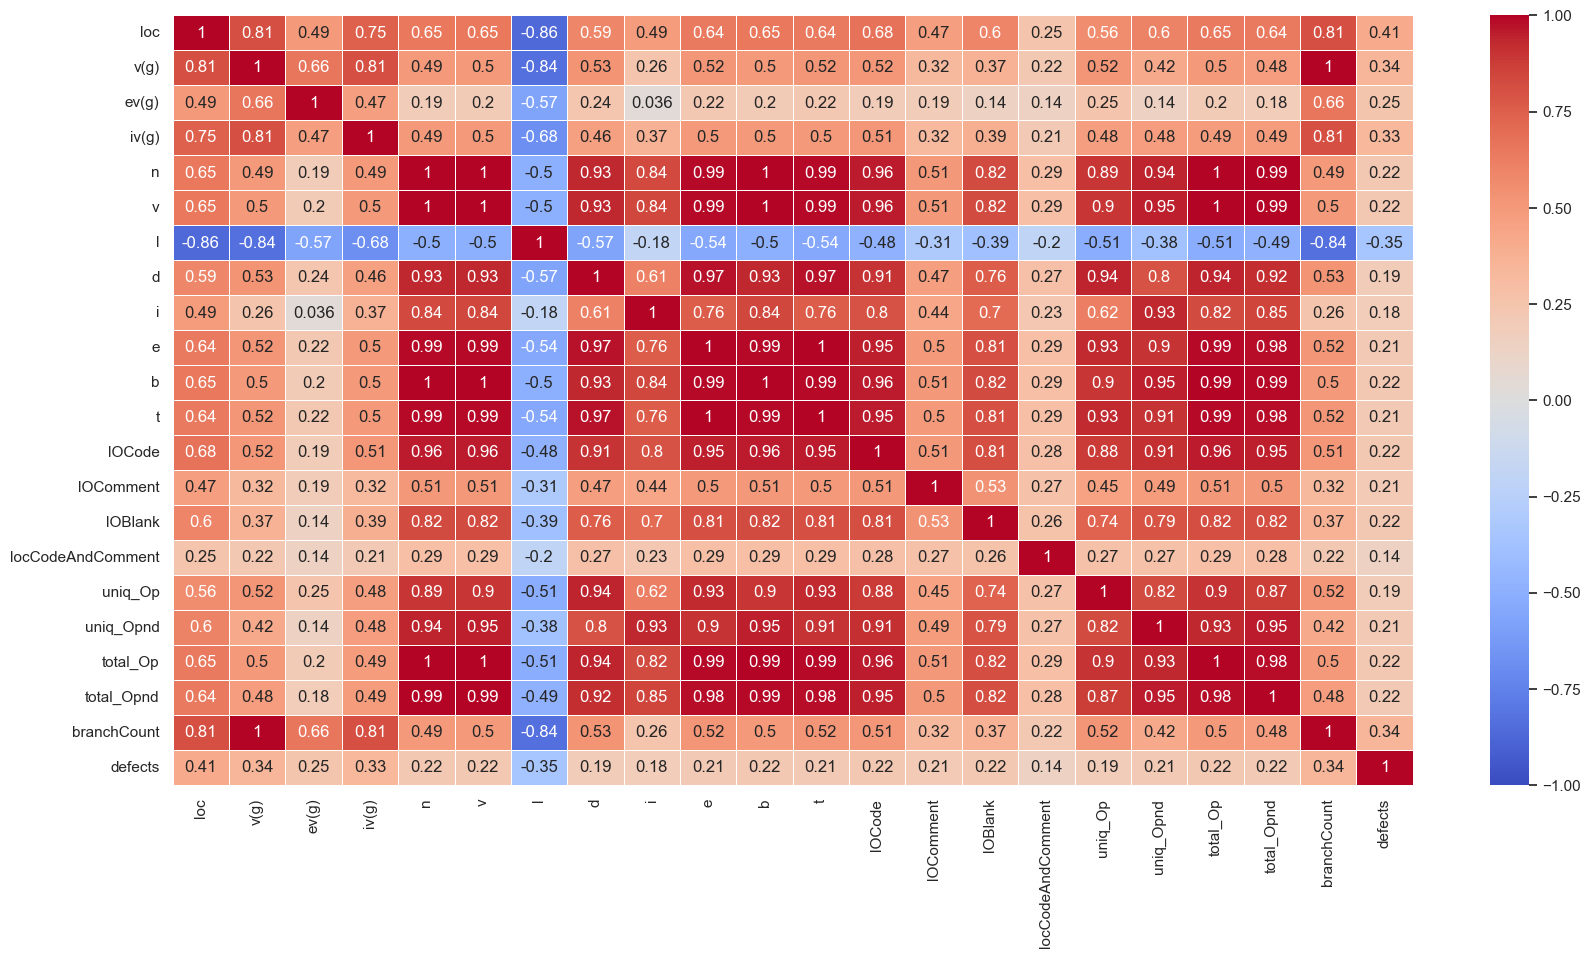

In [46]:
corr = train.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

<Axes: >

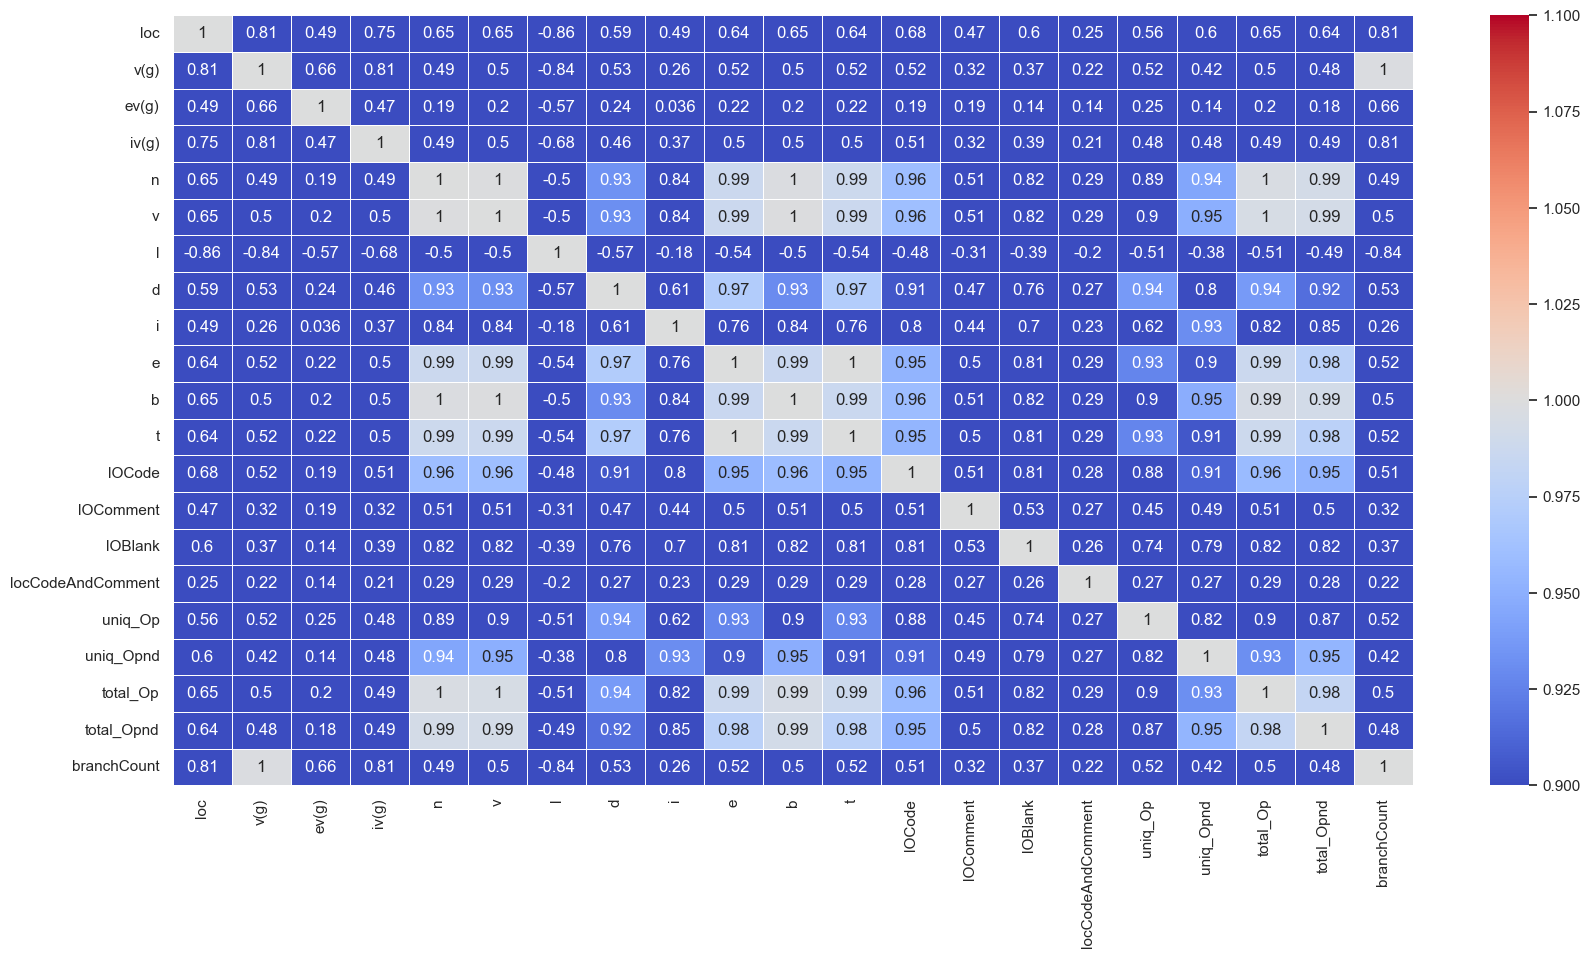

In [47]:
# 対数変換後の相関係数
correlation = X.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=1, vmax=1)

調べた結果を記述する
* 相関係数が1の組み合わせ
    - 'branchCount', 'v(g)'
    - 'n', 'v', 'b', 'total_Op'(bとは0.99)
    - 'e', 't'

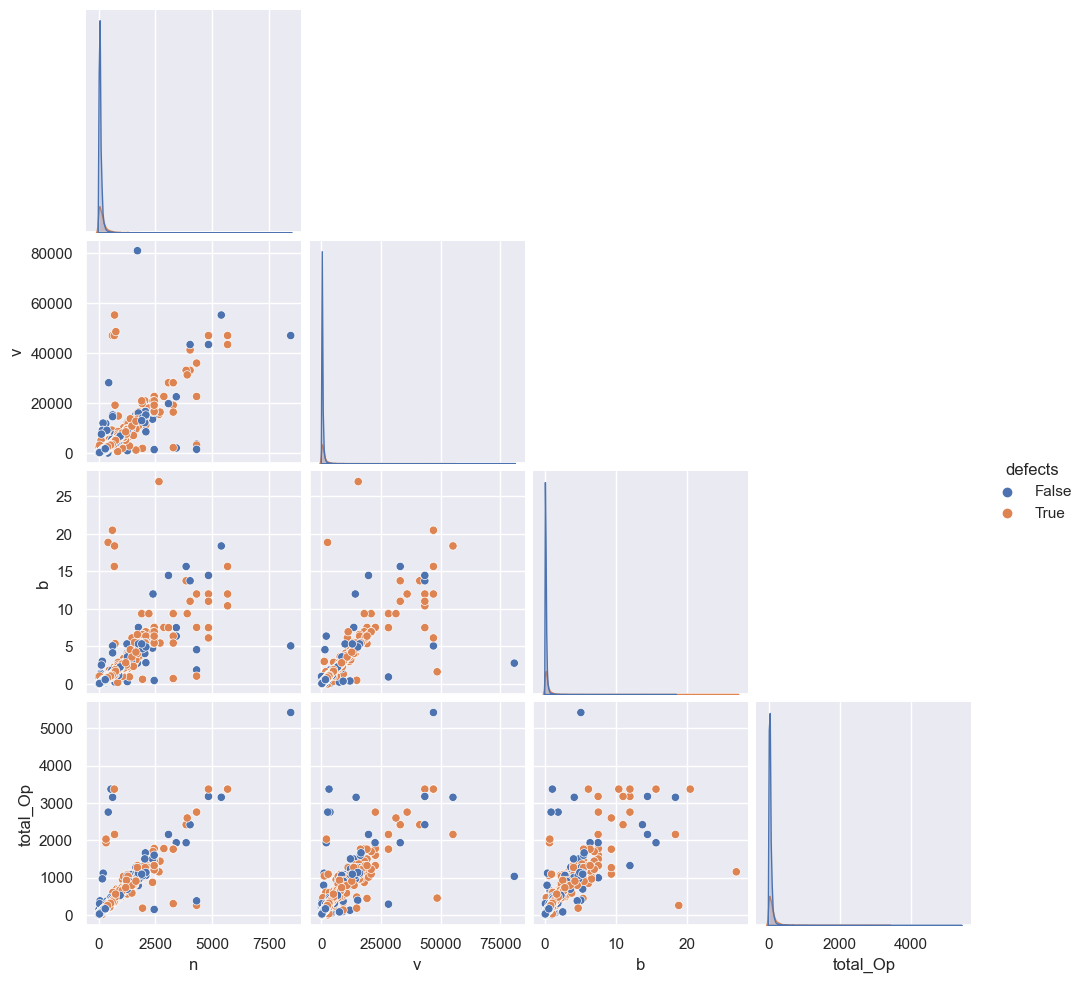

In [48]:
# 'n', 'v', 'b', 'total_Op'とdefects(目的変数)との相関関係を調べる
sns.pairplot(data=train[['n', 'v', 'b', 'total_Op', 'defects']], hue='defects', corner=True);

#### 相関(目的変数)

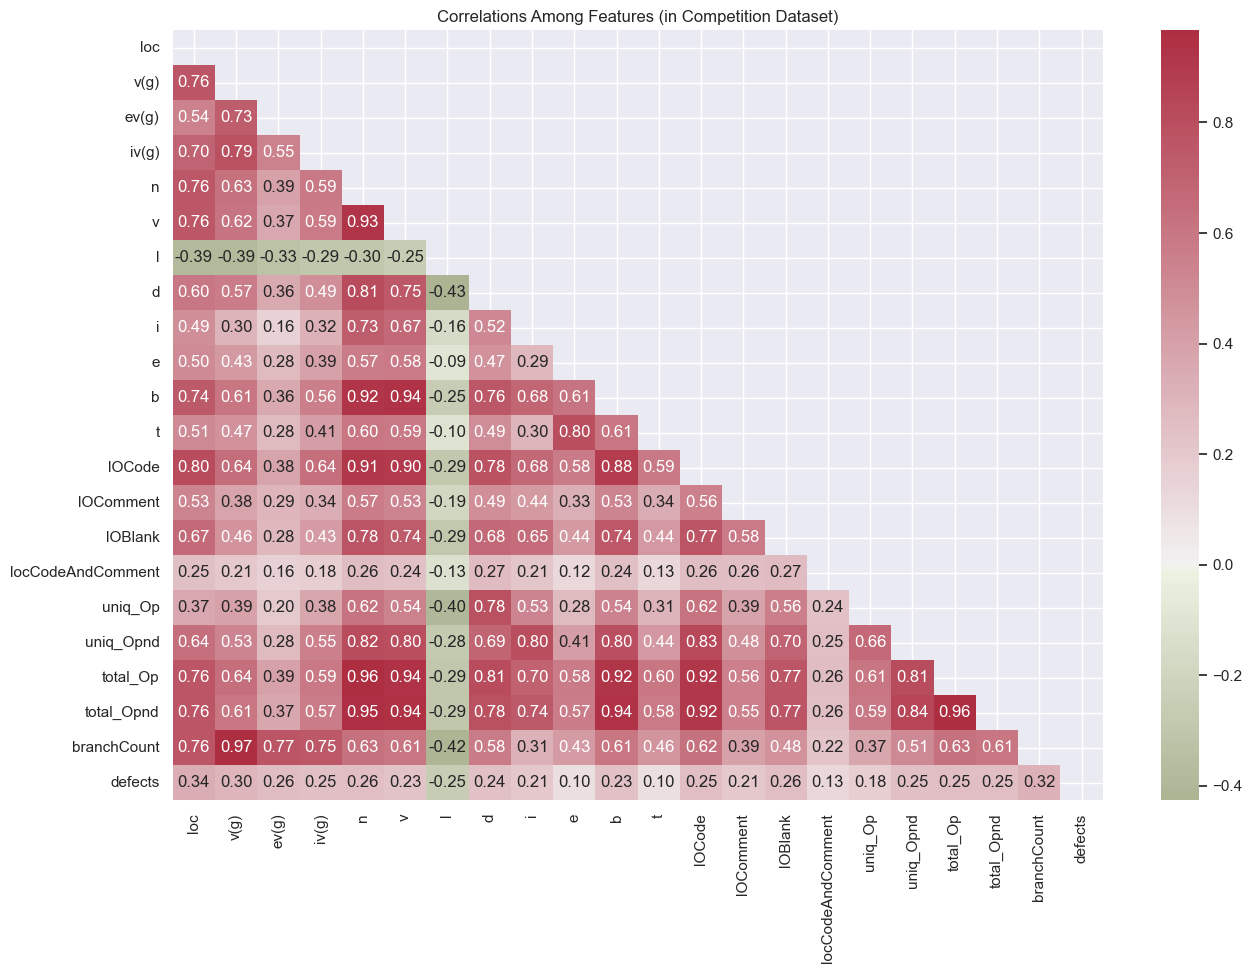

In [49]:
corr_mat_data = train.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

In [50]:
# 目的変数との相関の値が高い順に表示する
corr_target_data = train.corr()['defects'] # 目的変数を指定する
corr_target_data.sort_values(ascending=False)

defects              1.000000
loc                  0.342642
branchCount          0.322827
v(g)                 0.301187
ev(g)                0.259928
n                    0.258080
lOBlank              0.257819
total_Opnd           0.252752
lOCode               0.250604
total_Op             0.250533
uniq_Opnd            0.246113
iv(g)                0.245618
d                    0.241936
b                    0.232594
v                    0.231179
i                    0.208577
lOComment            0.205402
uniq_Op              0.178474
locCodeAndComment    0.133150
t                    0.099592
e                    0.095366
l                   -0.253237
Name: defects, dtype: float64

In [61]:
# 目的変数と最も相関係数が高い説明変数の値ごとのデータ数を数える
corr_1_size = train.groupby('loc').size() # 説明変数を指定する
corr_1_size.sort_values(ascending=False).head(10)

loc
11.0    3657
12.0    3431
7.0     3426
17.0    3255
8.0     3109
10.0    3084
14.0    3083
15.0    2935
9.0     2797
13.0    2713
dtype: int64

#### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

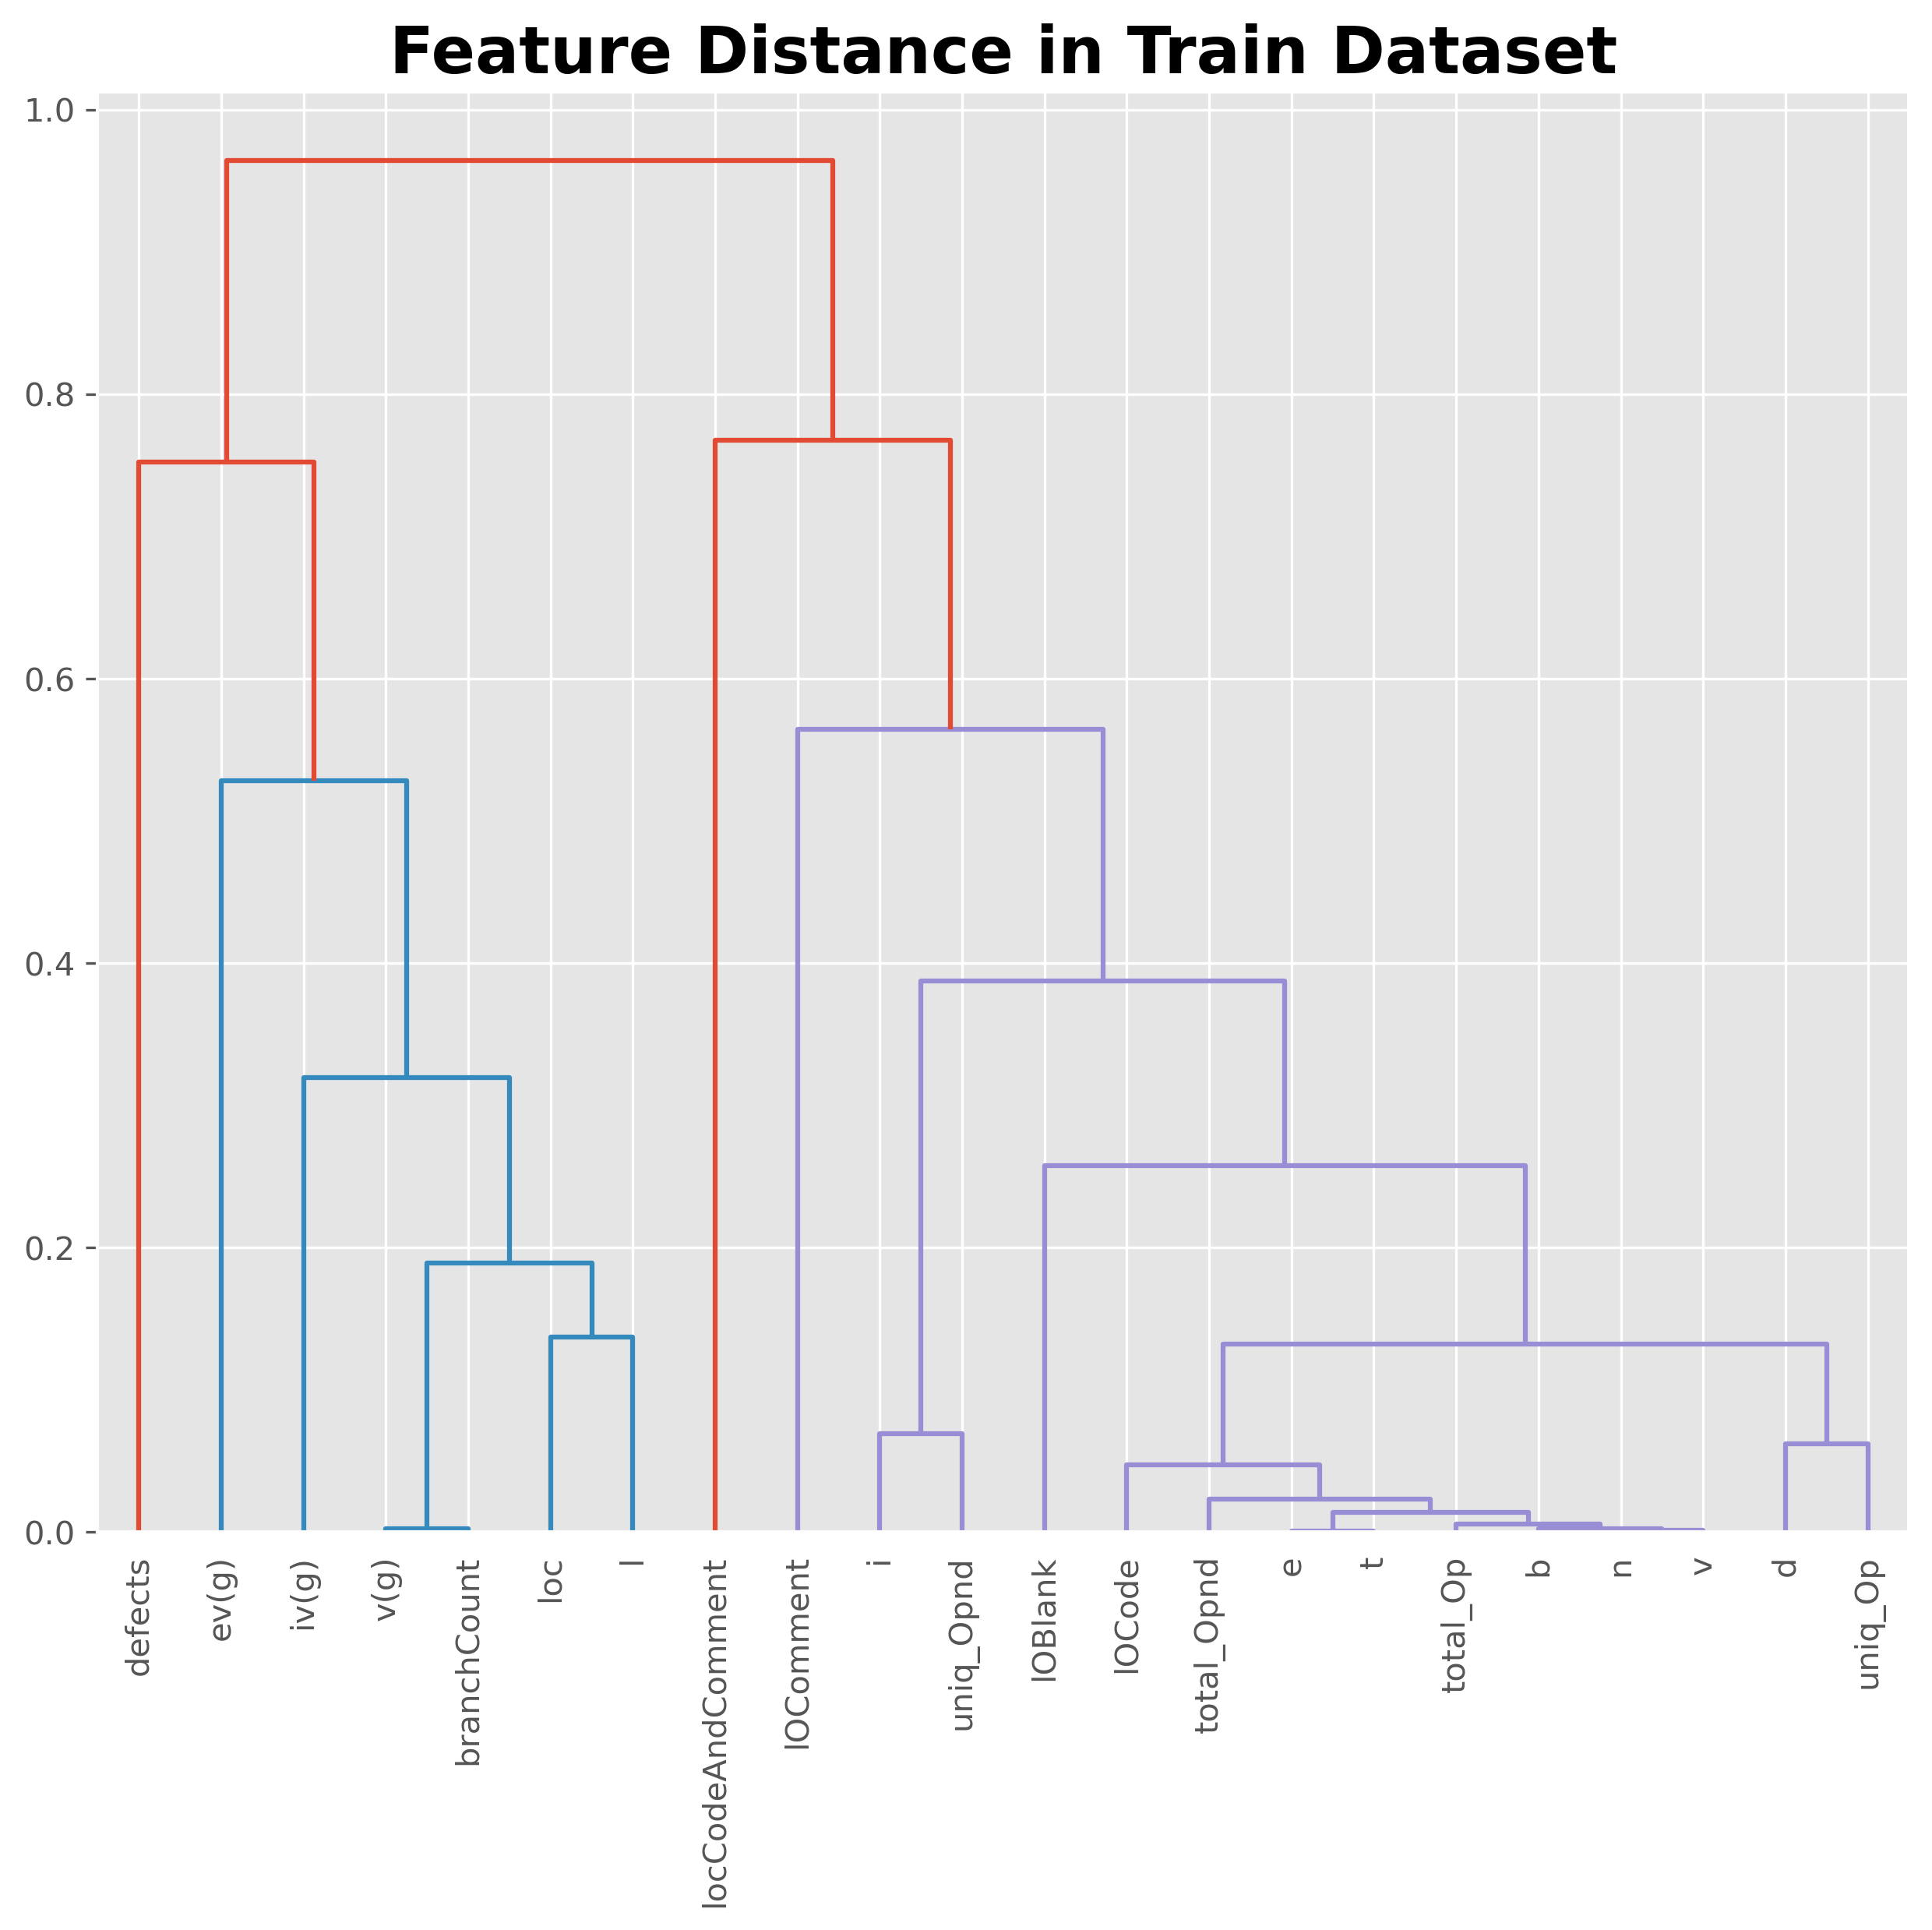

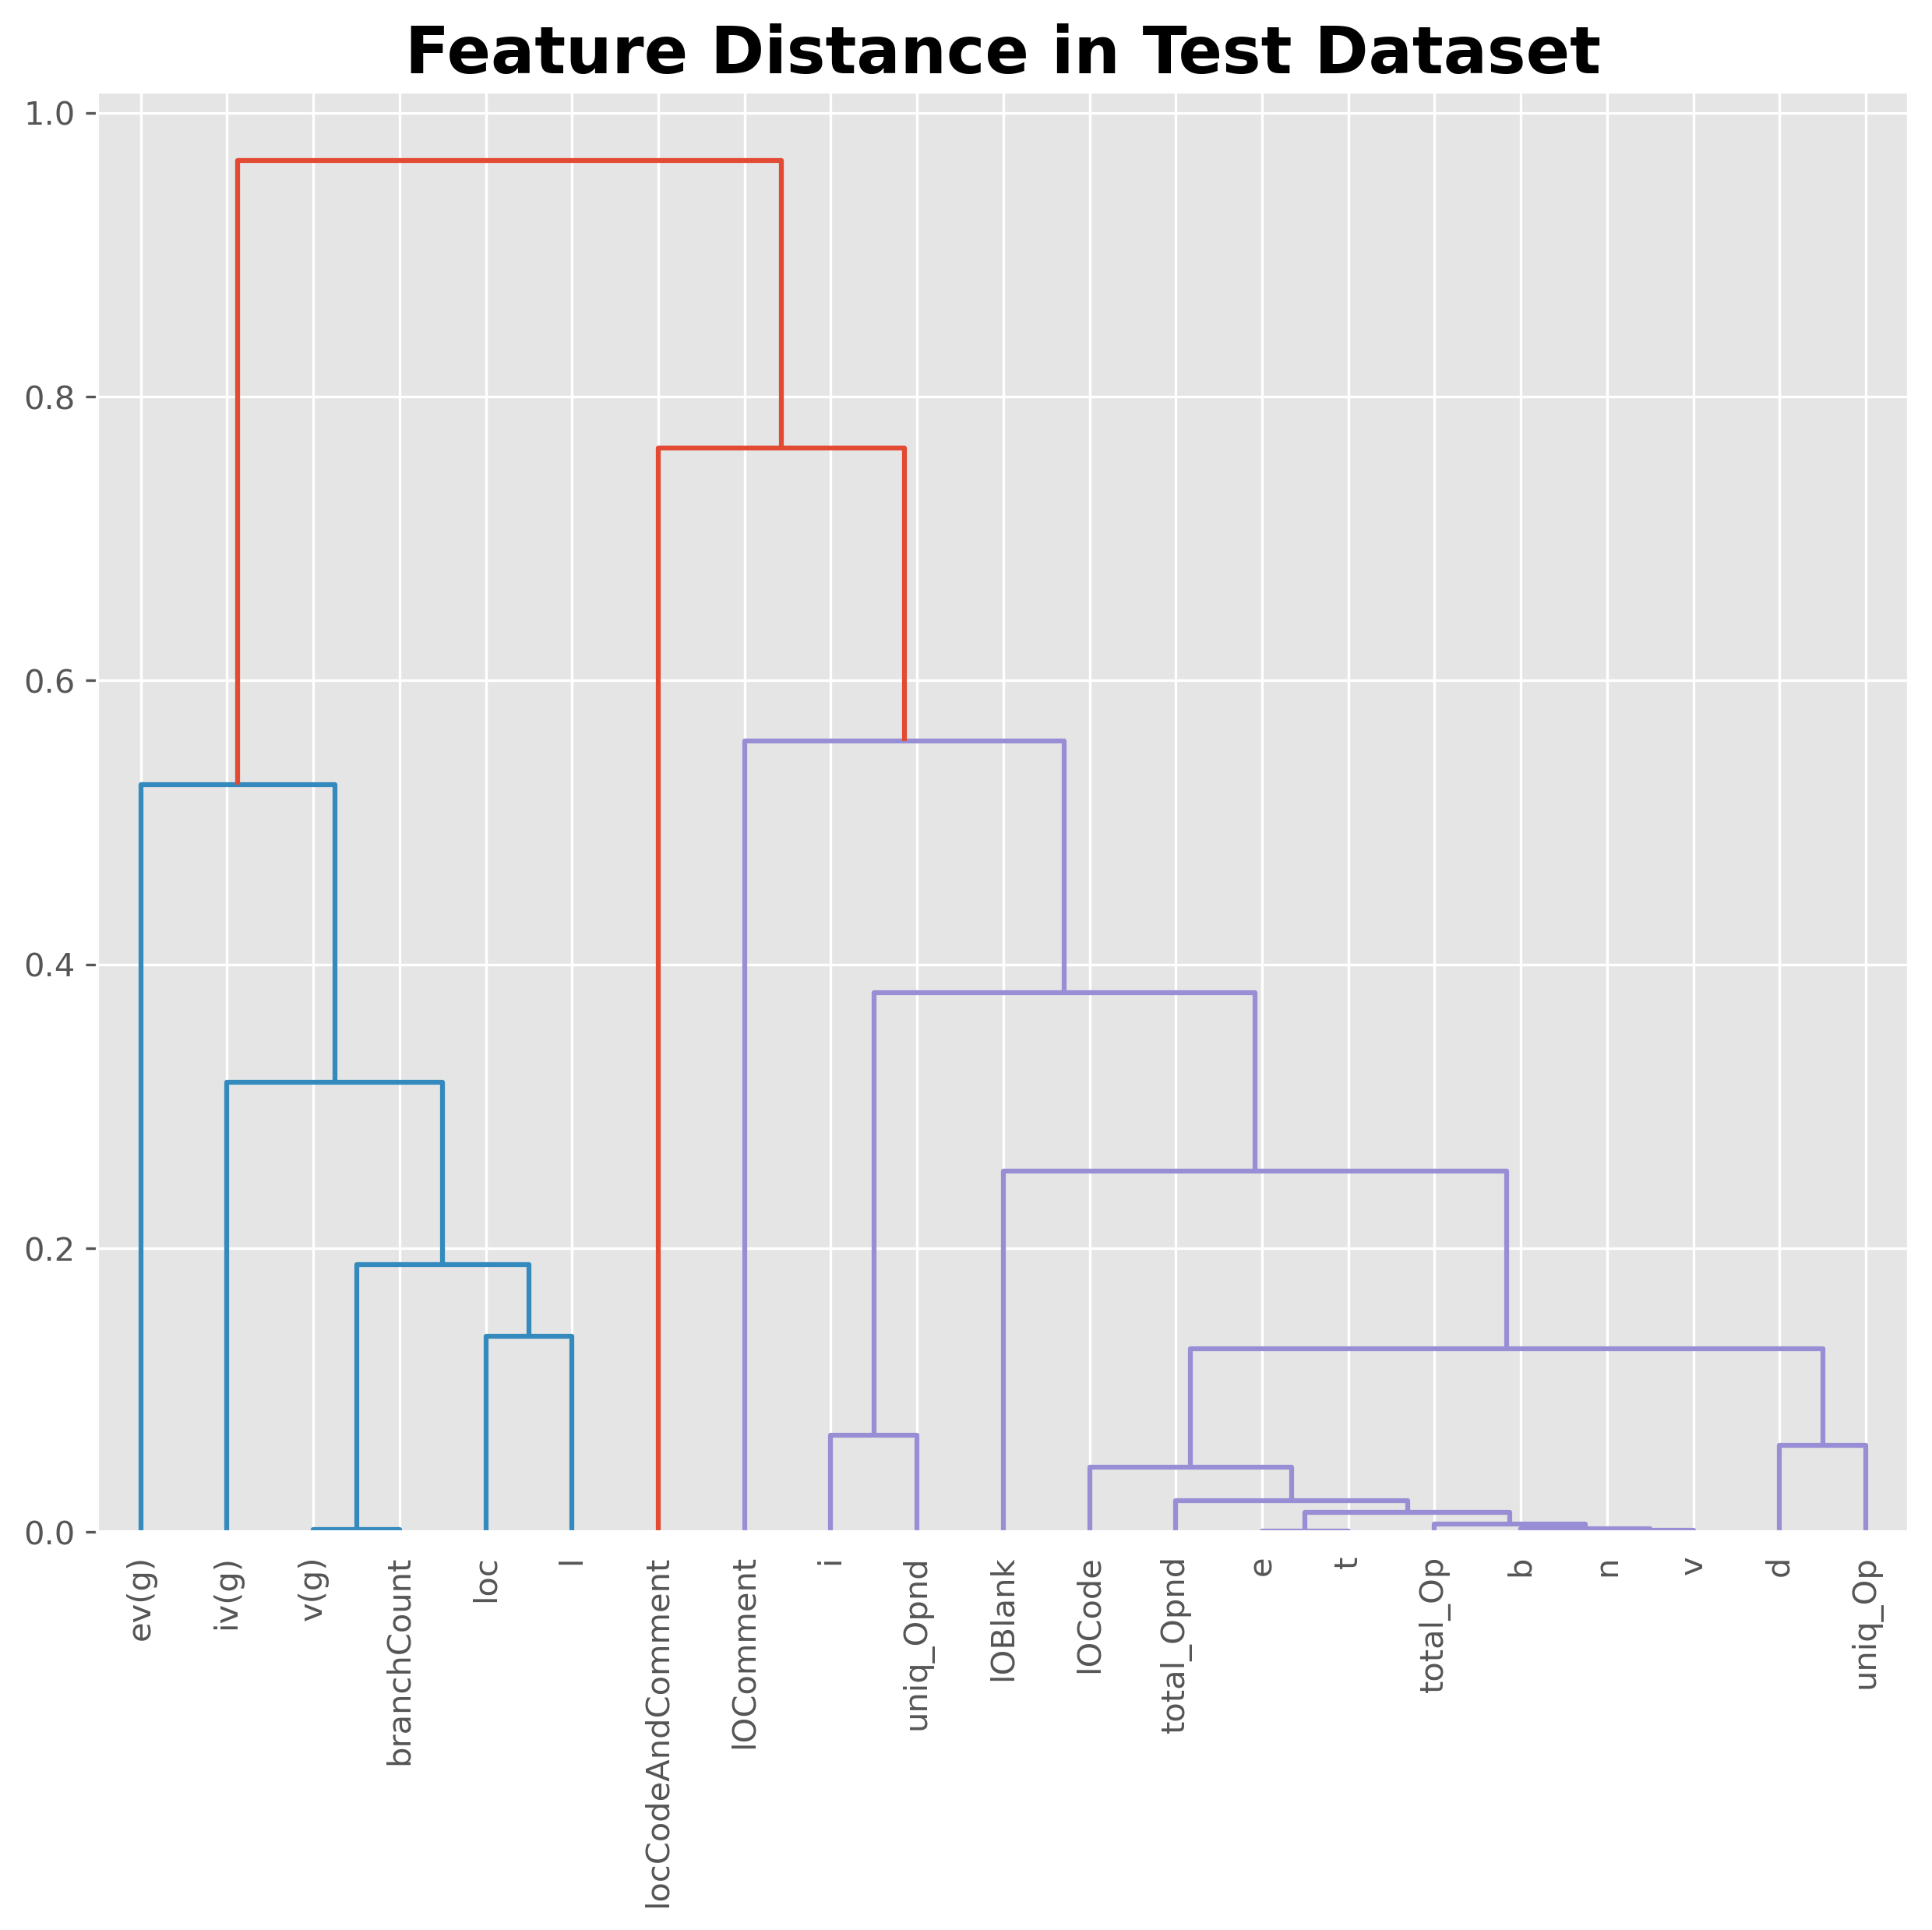

In [24]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8), dpi = 300)
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train, 'Train')
distance(test, 'Test')

## 目的変数

In [52]:
# 目的変数を数える
print(f'{target.value_counts()}\n\n')
print('値の相対的な出現頻度')
print(target.value_counts() / train.shape[0]) # 値の相対的な出現頻度

defects
0    78699
1    23064
Name: count, dtype: int64


値の相対的な出現頻度
defects
0    0.773356
1    0.226644
Name: count, dtype: float64


### データの抽出

In [53]:
train[train['defects'] == True] # 条件（フィルター）

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
11,8.0,1.0,1.0,1.0,15.0,51.89,0.19,5.25,9.88,272.43,0.02,15.14,5,0,1,0,7.0,4.0,8.0,7.0,1.0,True
14,6.0,1.0,1.0,1.0,17.0,58.81,0.19,5.25,11.20,276.75,0.02,15.38,3,0,0,0,7.0,4.0,12.0,6.0,1.0,True
16,126.0,13.0,6.0,7.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.0,0.0,0.0,0.0,25.0,True
18,40.0,9.0,3.0,7.0,151.0,823.92,0.04,23.33,35.54,22476.10,0.27,1248.67,32,0,8,2,18.0,21.0,95.0,56.0,17.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101739,79.0,12.0,7.0,8.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.0,0.0,0.0,0.0,23.0,True
101741,23.0,3.0,1.0,3.0,64.0,310.91,0.09,11.20,27.21,3318.18,0.10,184.34,14,0,2,0,14.0,15.0,33.0,29.0,5.0,True
101746,48.0,9.0,4.0,7.0,129.0,713.14,0.04,26.00,27.24,18539.72,0.24,1029.98,35,0,11,0,26.0,22.0,77.0,52.0,15.0,True
101748,104.0,23.0,8.0,12.0,396.0,2467.19,0.02,45.54,56.27,116471.96,0.82,6470.66,85,7,7,0,29.0,54.0,249.0,147.0,45.0,True


In [10]:
print(target_name +' Class labels:', np.unique(target))

['defects'] Class labels: [0 1]


メモ
* **得られた情報**
    - 概要
		* 評価指標
    - データの構成
    - データ数・型
    - カラム名・数
- EDA
    - 要約統計量
    - 欠損値
    - 尖度・歪度
    - 分布
        * 密度関数
            * 対数変換したデータ
        * 円グラフ
			* ヒストグラム
        * 箱ひげ図
        * 特徴量の重要度評価
        * 相関（ヒートマップ）
			* 散布図
    - 目的変数
		- EDAの可視化するためのライブラリ

## EDAの可視化するためのライブラリ

### sweetviz

In [37]:
report = sv.compare([train, "Train"], [test, "Test"])
report.show_html(OUTPUT_DIR + "EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /Users/ootsuka/Desktop/プログラミング/Kaggle/ソフトウェア欠陥データセットによるバイナリ分類/output/EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


0:114: execution error: ファイル“不特定のオブジェクト”が見つかりませんでした。 (-43)


## 実行時間を調べるために使う

In [55]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'17m47s'